# **1. Setup and Imports**


This section initializes the execution environment for the FD004 CMAPSS pipeline.
Key tasks include reproducibility seeding, optional Google Drive mounting, and validation of dataset file paths.
Ensuring correct file locations early prevents silent downstream failures in data loading, preprocessing, and model training.

In [2]:
# 1. Setup and Imports

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simple helper for consistent console logs
def log(msg: str):
    print(f"[INFO] {msg}")

# Reproducibility settings
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

log(f"Seed fixed at {SEED} for reproducibility.")

# Google Drive mount when running in Colab
try:
    from google.colab import drive
    log("Colab environment detected. Mounting Google Drive...")
    drive.mount('/content/drive')
    log("Drive mount complete")
except ImportError:
    log("Not running in Colab — skipping drive.mount().")

# Base directory for FD004 dataset
BASE_PATH_FD004 = "/content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps"

train_path_fd004 = os.path.join(BASE_PATH_FD004, "train_FD004.txt")
test_path_fd004  = os.path.join(BASE_PATH_FD004, "test_FD004.txt")
rul_path_fd004   = os.path.join(BASE_PATH_FD004, "RUL_FD004.txt")

log("FD004 expected file paths:")
print("   Train:", train_path_fd004)
print("   Test :", test_path_fd004)
print("   RUL  :", rul_path_fd004)

# Quick sanity check for missing files
missing = []
for p in [train_path_fd004, test_path_fd004, rul_path_fd004]:
    if os.path.exists(p):
        print(f"[FD004][OK]   Found: {p}")
    else:
        print(f"[FD004][MISS] Missing: {p}")
        missing.append(p)

if missing:
    raise FileNotFoundError(
        "ERROR: Required FD004 files are missing:\n" +
        "\n".join(missing)
    )

log("Setup and path validation complete.")


[INFO] Seed fixed at 42 for reproducibility.
[INFO] Colab environment detected. Mounting Google Drive...
Mounted at /content/drive
[INFO] Drive mount complete
[INFO] FD004 expected file paths:
   Train: /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/train_FD004.txt
   Test : /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/test_FD004.txt
   RUL  : /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/RUL_FD004.txt
[FD004][OK]   Found: /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/train_FD004.txt
[FD004][OK]   Found: /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/test_FD004.txt
[FD004][OK]   Found: /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/RUL_FD004.txt
[INFO] Setup and path validation complete.


# **2. Define FD004 File Paths**

All FD004 paths are standardized to maintain alignment with FD001–FD003 pipelines.
Using a central base directory ensures consistency, portability, and minimal refactoring when migrating notebooks or running in different environments.

In [3]:
# 2. Load FD004 Raw Data


# Base directory for all FD004 CMAPSS files.
base_path_fd004 = BASE_PATH_FD004

train_path_fd004 = f"{base_path_fd004}/train_FD004.txt"
test_path_fd004  = f"{base_path_fd004}/test_FD004.txt"
rul_path_fd004   = f"{base_path_fd004}/RUL_FD004.txt"

print("Paths set for FD004:")
print("  Train:", train_path_fd004)
print("  Test :", test_path_fd004)
print("  RUL  :", rul_path_fd004)


Paths set for FD004:
  Train: /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/train_FD004.txt
  Test : /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/test_FD004.txt
  RUL  : /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/RUL_FD004.txt


# **3. Load Raw Dataset Files (FD004)**

Raw CMAPSS data for FD004 is loaded using the NASA-specified column schema.
This cell produces the base train/test DataFrames from which all further preprocessing, feature engineering, and sequence construction will be derived.

In [4]:
# 3. LOAD RAW FD004 DATA

# cmaps layout for fd004: id, settings, then sensors
fd004_cols = ["unit", "cycle", "setting1", "setting2", "setting3"] + [
    f"sensor{i}" for i in range(1, 22)
]

train_fd004 = pd.read_csv(train_path_fd004, sep=r"\s+", header=None, names=fd004_cols)
test_fd004  = pd.read_csv(test_path_fd004,  sep=r"\s+", header=None, names=fd004_cols)
# rul file is just a single column
rul_fd004   = pd.read_csv(rul_path_fd004,   sep=r"\s+", header=None)[0]

print("FD004 Train Shape:", train_fd004.shape)
print("FD004 Test Shape :", test_fd004.shape)
print("FD004 RUL Shape  :", rul_fd004.shape)
print("\nfd004 train head:")
display(train_fd004.head())


FD004 Train Shape: (61249, 26)
FD004 Test Shape : (41214, 26)
FD004 RUL Shape  : (248,)

fd004 train head:


,unit,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


# **4. Quick sanity checks on fd004 data**

Quick look at structure, missing values, duplicates, and unit counts for train/test.
Nothing fancy here, just making sure the raw load is not broken before going deeper.

In [5]:
# 4.basic structure / quality checks on fd004 train + test


print("=== fd004 train basic info ===")
display(train_fd004.head())
print("\ntrain shape:", train_fd004.shape)

print("\n Data types:")
print(train_fd004.dtypes)

print("\n Missing values (train):")
print(train_fd004.isna().sum())

print("\n Duplicate rows in TRAIN:", train_fd004.duplicated().sum())
print(" Duplicate rows in TEST :", test_fd004.duplicated().sum())

print("\n=== ENGINE COUNTS (FD004) ===")
print("Unique engines in TRAIN:", train_fd004["unit"].nunique())
print("Unique engines in TEST :", test_fd004["unit"].nunique())

print("\nsample test rows:")
display(test_fd004.head())

print("\nfd004 basic checks done, nothing obviously broken.")


=== fd004 train basic info ===


,unit,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754



train shape: (61249, 26)

 Data types:
unit          int64
cycle         int64
setting1    float64
setting2    float64
setting3    float64
sensor1     float64
sensor2     float64
sensor3     float64
sensor4     float64
sensor5     float64
sensor6     float64
sensor7     float64
sensor8     float64
sensor9     float64
sensor10    float64
sensor11    float64
sensor12    float64
sensor13    float64
sensor14    float64
sensor15    float64
sensor16    float64
sensor17      int64
sensor18      int64
sensor19    float64
sensor20    float64
sensor21    float64
dtype: object

 Missing values (train):
unit        0
cycle       0
setting1    0
setting2    0
setting3    0
sensor1     0
sensor2     0
sensor3     0
sensor4     0
sensor5     0
sensor6     0
sensor7     0
sensor8     0
sensor9     0
sensor10    0
sensor11    0
sensor12    0
sensor13    0
sensor14    0
sensor15    0
sensor16    0
sensor17    0
sensor18    0
sensor19    0
sensor20    0
sensor21    0
dtype: int64

 Duplicate rows in TRA

,unit,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,313.03,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,163.61,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,129.98,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,129.48,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,181.82,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326



fd004 basic checks done, nothing obviously broken.


# **5. PER-ENGINE CYCLE STATS & VISUALIZATION (FD004)**

Checking how many cycles each engine runs before failure in FD004.
Gives a feel for run-length spread and how many very short sequences exist.

[INFO] checking per-engine cycle stats for FD004...
per-engine max cycle stats:


,cycle
count,249.00000
mean,245.97992
std,73.11080
min,128.00000
25%,190.00000
50%,234.00000
75%,290.00000
max,543.00000


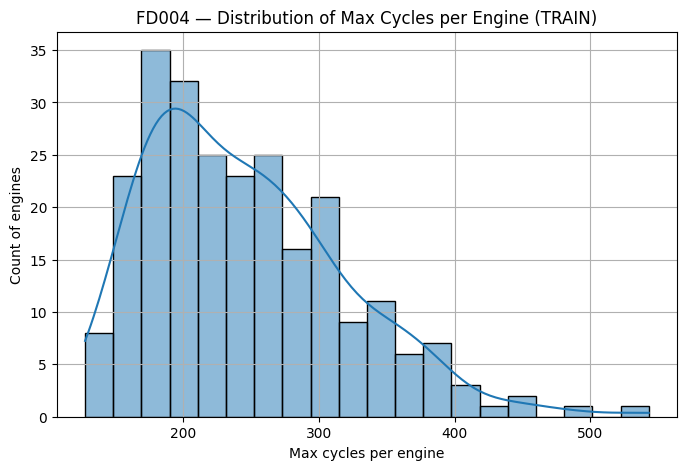


Min cycles: 128
Max cycles: 543
Engines with very short runs (<=50 cycles): 0
[INFO] per-engine cycle distribution plotted


In [6]:
# 5. PER-ENGINE CYCLE STATS & VISUALIZATION (FD004)
# look at max cycle per engine to understand run lengths

log("checking per-engine cycle stats for FD004...")
print("per-engine max cycle stats:")
cycles_per_engine_fd004 = train_fd004.groupby("unit")["cycle"].max()
display(cycles_per_engine_fd004.describe())

plt.figure(figsize=(8,5))
sns.histplot(cycles_per_engine_fd004, bins=20, kde=True)
plt.title("FD004 — Distribution of Max Cycles per Engine (TRAIN)")
plt.xlabel("Max cycles per engine")
plt.ylabel("Count of engines")
plt.grid(True)
plt.show()

print("\nMin cycles:", cycles_per_engine_fd004.min())
print("Max cycles:", cycles_per_engine_fd004.max())
print("Engines with very short runs (<=50 cycles):",
      (cycles_per_engine_fd004 <= 50).sum())

log("per-engine cycle distribution plotted")


# **6. Settings distribution (fd004)**


Quick look at the three operating settings in FD004.
Just checking ranges and distributions before worrying about sensors.

FD004 — SETTINGS SUMMARY (TRAIN)


,setting1,setting2,setting3
count,61249.000000,61249.000000,61249.000000
mean,23.999823,0.571347,94.031576
std,14.780722,0.310703,14.251954
min,0.000000,0.000000,60.000000
25%,10.004600,0.250700,100.000000
50%,25.001400,0.700000,100.000000
75%,41.998100,0.840000,100.000000
max,42.008000,0.842000,100.000000


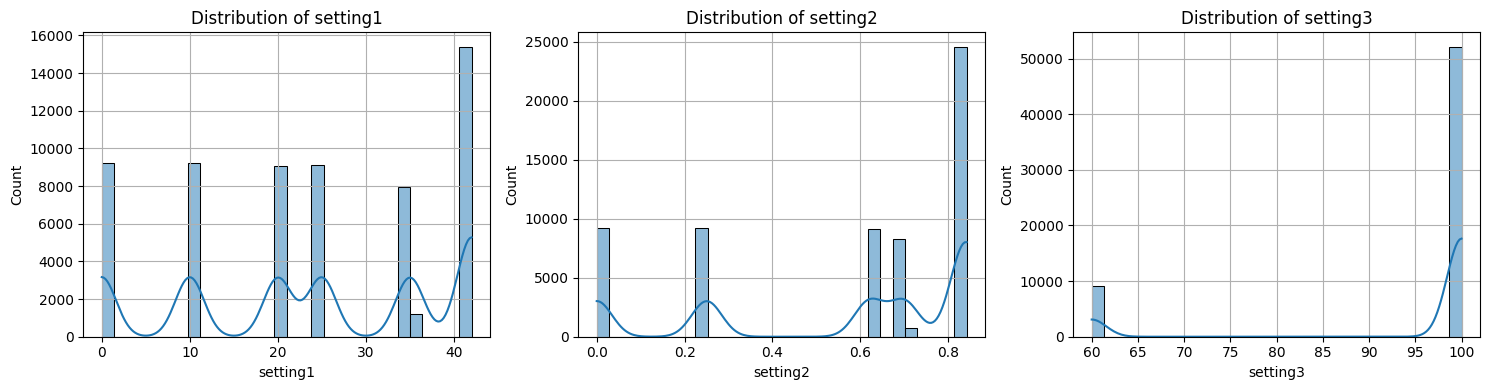


 Settings look numerically sensible for FD004 (no NaNs, no obvious out-of-range spikes).


In [7]:
# 6. SETTINGS DISTRIBUTION & BASIC VISUAL CHECKS (FD004)

# basic summary + histograms for the 3 operating settings
setting_cols_fd004 = ["setting1", "setting2", "setting3"]

print("FD004 — SETTINGS SUMMARY (TRAIN)")
display(train_fd004[setting_cols_fd004].describe())

fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, col in enumerate(setting_cols_fd004):
    sns.histplot(train_fd004[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].grid(True)
plt.tight_layout()
plt.show()

print("\n Settings look numerically sensible for FD004 (no NaNs, no obvious out-of-range spikes).")


# **7. SENSOR STATS, NEAR-CONSTANT DETECTION & CORRELATION**

A statistical overview of sensor signals is performed to identify near-constant sensors and redundant features.
Low-variance sensors are typically non-informative for RUL modeling and can degrade neural sequence model performance if not removed.

FD004 sensor summary (train, first 15):


,count,mean,std,min,25%,50%,75%,max
sensor1,61249.0,472.882435,26.436832,445.0000,445.000,462.5400,491.1900,518.6700
sensor2,61249.0,579.420056,37.342647,535.4800,549.330,555.7400,607.0700,644.4200
sensor3,61249.0,1417.896600,106.167598,1242.6700,1350.550,1367.6800,1497.4200,1613.0000
sensor4,61249.0,1201.915359,119.327591,1024.4200,1119.490,1136.9200,1302.6200,1440.7700
sensor5,61249.0,8.031626,3.622872,3.9100,3.910,7.0500,10.5200,14.6200
sensor6,61249.0,11.589457,5.444017,5.6700,5.720,9.0300,15.4800,21.6100
sensor7,61249.0,283.328633,146.880210,136.1700,142.920,194.9600,394.2800,570.8100
sensor8,61249.0,2228.686034,145.348243,1914.7200,2211.950,2223.0700,2323.9300,2388.6400
sensor9,61249.0,8524.673301,336.927547,7984.5100,8320.590,8362.7600,8777.2500,9196.8100
sensor10,61249.0,1.096445,0.127681,0.9300,1.020,1.0300,1.2600,1.3200



 Sensor standard deviations (first 15):


,0
sensor1,26.436832
sensor2,37.342647
sensor3,106.167598
sensor4,119.327591
sensor5,3.622872
sensor6,5.444017
sensor7,146.880210
sensor8,145.348243
sensor9,336.927547
sensor10,0.127681



 Near-constant sensor columns in FD004 (std < 1e-06):
[]


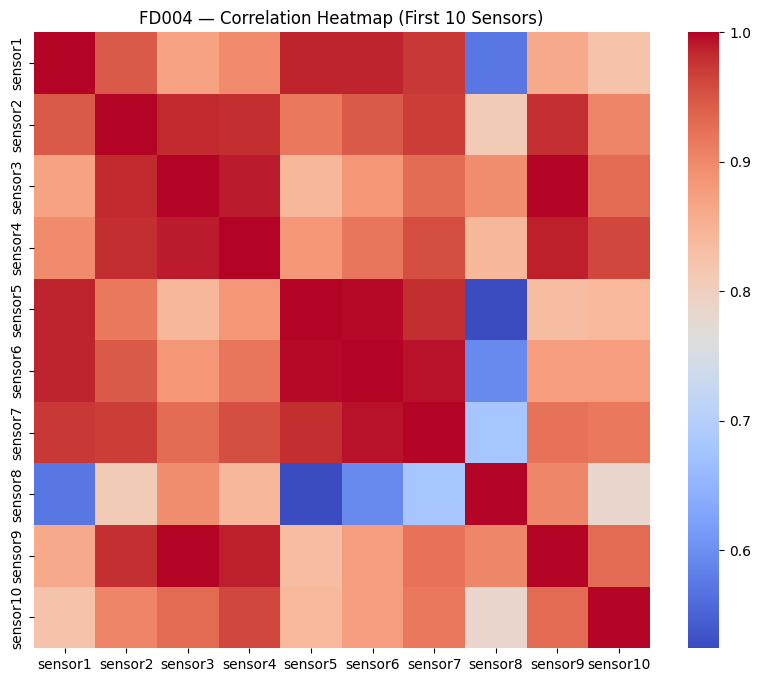


21 sensors total, 0 near-constant.


In [8]:

# 7. SENSOR STATS, NEAR-CONSTANT DETECTION & CORRELATION


# sensors only (leave settings alone)
sensor_cols_fd004 = [c for c in train_fd004.columns if c.startswith("sensor")]

print("FD004 sensor summary (train, first 15):")
display(train_fd004[sensor_cols_fd004].describe().T.head(15))

# Standard deviation of each sensor
sensor_std_fd004 = train_fd004[sensor_cols_fd004].std()
print("\n Sensor standard deviations (first 15):")
display(sensor_std_fd004.head(15))

# Threshold to detect practically constant sensors
STD_THRESHOLD = 1e-6
constant_cols_fd004 = sensor_std_fd004[sensor_std_fd004 < STD_THRESHOLD].index.tolist()

print(f"\n Near-constant sensor columns in FD004 (std < {STD_THRESHOLD}):")
print(constant_cols_fd004)

# Quick correlation heatmap for first 10 sensors (before dropping)
subset_sensors_fd004 = sensor_cols_fd004[:10]
plt.figure(figsize=(10, 8))
corr_fd004 = train_fd004[subset_sensors_fd004].corr()
sns.heatmap(corr_fd004, annot=False, cmap="coolwarm", square=True)
plt.title("FD004 — Correlation Heatmap (First 10 Sensors)")
plt.show()

print(f"\n{len(sensor_cols_fd004)} sensors total, {len(constant_cols_fd004) or 0} near-constant.")


# **8. DROP NEAR-CONSTANT SENSORS (FD004)**

Removing sensors with std < 1e-6 from both train and test.
Settings stay untouched, only sensors get cleaned.

In [9]:
# 8. DROP NEAR-CONSTANT SENSORS (FD004)


print("Dropping near-constant sensor columns (FD004):", constant_cols_fd004)

# Drop only from sensor columns (settings stay untouched)
if constant_cols_fd004:
    train_fd004.drop(columns=constant_cols_fd004, inplace=True)
    test_fd004.drop(columns=constant_cols_fd004, inplace=True)
else:
    print("No near-constant sensors detected — nothing to drop.")

# Recompute sensor_cols after dropping
sensor_cols_fd004 = [c for c in train_fd004.columns if c.startswith("sensor")]

print("\n After dropping near-constant sensors (FD004):")
print("Train shape:", train_fd004.shape)
print("Test  shape:", test_fd004.shape)
print("Remaining sensors:", len(sensor_cols_fd004))
print(sensor_cols_fd004)


Dropping near-constant sensor columns (FD004): []
No near-constant sensors detected — nothing to drop.

 After dropping near-constant sensors (FD004):
Train shape: (61249, 26)
Test  shape: (41214, 26)
Remaining sensors: 21
['sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21']


# **9. GENERATE RUL FOR TRAINING DATA (FD004)**

Calculate remaining useful life (RUL) as max cycle minus current cycle per unit.
This is the target variable for training.

- For each engine (`unit`), find its **maximum cycle** in the training data.
- Compute **Remaining Useful Life (RUL)** for every row as:
  \[
  \text{RUL} = \text{max\_cycle (for that engine)} - \text{current cycle}
  \]
- Add two new columns to `train_fd004`:
  - `max_cycle` – final cycle for that engine.
  - `RUL` – remaining cycles until failure at each time step.
- Show a small sample of `unit`, `cycle`, `max_cycle`, and `RUL` to confirm the logic.
- Plot the **RUL distribution** before any capping to understand how many early vs late points we have.
- Sanity check:
  - For every engine, the **last row** should have `RUL = 0`.  
  - Print the unique RUL values at the last cycles to verify this.

[INFO] Generating RUL labels for FD004 training data...
Sample RUL values (FD004) 


,unit,cycle,max_cycle,RUL
0,1,1,321,320
1,1,2,321,319
2,1,3,321,318
3,1,4,321,317
4,1,5,321,316
5,1,6,321,315
6,1,7,321,314
7,1,8,321,313
8,1,9,321,312
9,1,10,321,311



RUL stats before capping


,RUL
count,61249.000000
mean,133.311417
std,89.783389
min,0.000000
25%,61.000000
50%,122.000000
75%,190.000000
max,542.000000


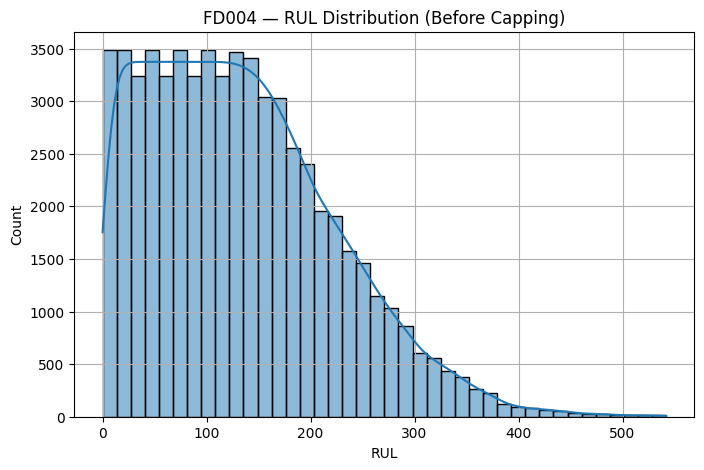


Sanity check — RUL at last cycle should be 0 (FD004):


,unit,cycle,max_cycle,RUL
320,1,321,321,0
619,2,299,299,0
926,3,307,307,0
1200,4,274,274,0
1393,5,193,193,0


Unique RUL at last cycles: [0]
[INFO] RUL generation completed.


In [10]:
# CELL 9 — GENERATE RUL FOR TRAINING DATA (FD004)


log("Generating RUL labels for FD004 training data...")

# For each engine: RUL = max_cycle - cycle

# max cycle per engine in training data
max_cycle_per_unit_fd004 = train_fd004.groupby("unit")["cycle"].max()

# map max cycle back to each row
train_fd004["max_cycle"] = train_fd004["unit"].map(max_cycle_per_unit_fd004)

# RUL = max cycle - current cycle
train_fd004["RUL"] = train_fd004["max_cycle"] - train_fd004["cycle"]

print("Sample RUL values (FD004) ")
display(train_fd004[["unit", "cycle", "max_cycle", "RUL"]].head(10))

print("\nRUL stats before capping")
display(train_fd004["RUL"].describe())

plt.figure(figsize=(8,5))
sns.histplot(train_fd004["RUL"], bins=40, kde=True)
plt.title("FD004 — RUL Distribution (Before Capping)")
plt.xlabel("RUL")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Sanity: last cycle per engine has RUL = 0
check_last_fd004 = train_fd004.groupby("unit").tail(1)
print("\nSanity check — RUL at last cycle should be 0 (FD004):")
display(check_last_fd004[["unit", "cycle", "max_cycle", "RUL"]].head())
print("Unique RUL at last cycles:", check_last_fd004["RUL"].unique()[:10])

log("RUL generation completed.")


# **10. Apply RUL Cap and Visualize Distribution(FD004)**

- To stabilize training and reduce extreme outliers, clip all RUL values using:
  \[
  \text{RUL} = \min(\text{RUL},\,125)
  \]
- This ensures the target values stay within a manageable range for sequence models.
- After applying the cap:
  - Display summary statistics to verify the new distribution.
  - Plot a histogram (with KDE) to visualize how the capped RUL values are spread.
- This step helps the model focus on learning realistic degradation patterns without being dominated by very large RUL values.

Applied RUL cap of 125 for FD004.
RUL stats after capping:


,RUL
count,61249.000000
mean,92.985192
std,40.665112
min,0.000000
25%,61.000000
50%,122.000000
75%,125.000000
max,125.000000


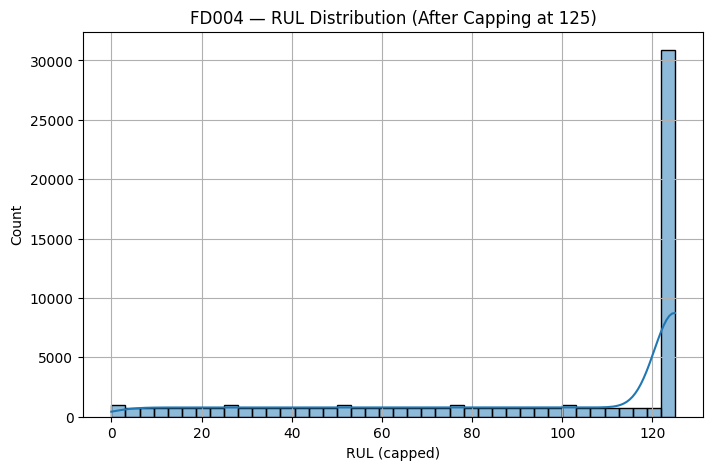

[INFO] RUL capping and plotting done.


In [11]:
# 10. APPLY RUL CAP (125) & VISUALIZE (FD004)


RUL_CAP_FD004 = 125

# cap RUL values
train_fd004["RUL"] = np.minimum(train_fd004["RUL"], RUL_CAP_FD004)

print(f"Applied RUL cap of {RUL_CAP_FD004} for FD004.")
print("RUL stats after capping:")
display(train_fd004["RUL"].describe())

plt.figure(figsize=(8,5))
sns.histplot(train_fd004["RUL"], bins=40, kde=True)
plt.title(f"FD004 — RUL Distribution (After Capping at {RUL_CAP_FD004})")
plt.xlabel("RUL (capped)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

log("RUL capping and plotting done.")


# **11. FEATURE COLUMN ANALYSIS & CONSTANT COLUMN REMOVAL**

This block finalizes feature selection by removing columns with no variation and defining the base feature set.
The resulting feature schema is the foundation for rolling, delta, scaling, and sequence-building steps.

In [12]:
# 11. FEATURE COLUMN ANALYSIS & CONSTANT COLUMN REMOVAL


print("FD004 FEATURE COLUMN ANALYSIS ")

# ID, settings, sensors (re-derive after earlier drops)
id_cols_fd004      = ["unit", "cycle"]
setting_cols_fd004 = ["setting1", "setting2", "setting3"]
sensor_cols_fd004  = [c for c in train_fd004.columns if c.startswith("sensor")]

print("ID columns      :", id_cols_fd004)
print("Setting columns :", setting_cols_fd004)
print("Sensor columns  :", sensor_cols_fd004)
print("Total sensors   :", len(sensor_cols_fd004))

# find constant columns (zero variance) among settings + sensors
constant_columns_fd004 = []

for col in setting_cols_fd004 + sensor_cols_fd004:
    if train_fd004[col].nunique() == 1:
        constant_columns_fd004.append(col)

print("\nConstant (zero-variance) columns in FD004:", constant_columns_fd004)

# drop constant columns from train + test safely (ignore errors)
train_fd004_clean = train_fd004.drop(columns=constant_columns_fd004, errors="ignore").copy()
test_fd004_clean  = test_fd004.drop(columns=constant_columns_fd004, errors="ignore").copy()

print("\nTRAIN shape before:", train_fd004.shape)
print("TRAIN shape after removing constant cols:", train_fd004_clean.shape)

print("\nTEST shape before :", test_fd004.shape)
print("TEST shape after removing constant cols :", test_fd004_clean.shape)

# collect base feature columns for next steps (exclude id + target + max_cycle)
exclude_cols_fd004_base = ["unit", "cycle", "RUL", "max_cycle"]
feature_cols_fd004 = [
    c for c in train_fd004_clean.columns
    if c not in exclude_cols_fd004_base
]

print("\nBase feature columns count (before rolling/delta):", len(feature_cols_fd004))
print("Sample base feature columns:", feature_cols_fd004[:10])


FD004 FEATURE COLUMN ANALYSIS 
ID columns      : ['unit', 'cycle']
Setting columns : ['setting1', 'setting2', 'setting3']
Sensor columns  : ['sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21']
Total sensors   : 21

Constant (zero-variance) columns in FD004: []

TRAIN shape before: (61249, 28)
TRAIN shape after removing constant cols: (61249, 28)

TEST shape before : (41214, 26)
TEST shape after removing constant cols : (41214, 26)

Base feature columns count (before rolling/delta): 24
Sample base feature columns: ['setting1', 'setting2', 'setting3', 'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7']


# **12. ROLLING WINDOW FEATURES (3,5 cycles) - fd004**

Add rolling mean/std features for sensors over windows of 3 and 5 cycles per engine.
This captures short-term trends in sensor readings.
These engineered features enrich model understanding of transient degradation patterns without requiring deep sequence lengths.

In [13]:
# 12.  ROLLING WINDOW FEATURES (FD004, 3 & 5 CYCLES)


print("GENERATING ROLLING FEATURES FOR FD004 (3 & 5 cycles) ")

df_fd004_roll = train_fd004_clean.copy()

rolling_windows_fd004 = [3, 5]

# current sensor columns after previous cleaning
sensor_cols_fd004_current = [c for c in df_fd004_roll.columns if c.startswith("sensor")]

# rolling mean + std for each sensor + window size
for w in rolling_windows_fd004:
    for col in sensor_cols_fd004_current:
        # rolling mean
        df_fd004_roll[f"{col}_roll{w}_mean"] = (
            df_fd004_roll.groupby("unit")[col]
            .rolling(window=w, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )
        # rolling std
        df_fd004_roll[f"{col}_roll{w}_std"] = (
            df_fd004_roll.groupby("unit")[col]
            .rolling(window=w, min_periods=1)
            .std()
            .reset_index(level=0, drop=True)
        )

print("Rolling feature generation complete for FD004.")
new_roll_cols_fd004 = [c for c in df_fd004_roll.columns if "roll" in c]
print("Total rolling columns added:", len(new_roll_cols_fd004))
print("Sample rolling feature columns:", new_roll_cols_fd004[:10])

print("\nUpdated FD004 TRAIN shape after rolling features:", df_fd004_roll.shape)


GENERATING ROLLING FEATURES FOR FD004 (3 & 5 cycles) 
Rolling feature generation complete for FD004.
Total rolling columns added: 84
Sample rolling feature columns: ['sensor1_roll3_mean', 'sensor1_roll3_std', 'sensor2_roll3_mean', 'sensor2_roll3_std', 'sensor3_roll3_mean', 'sensor3_roll3_std', 'sensor4_roll3_mean', 'sensor4_roll3_std', 'sensor5_roll3_mean', 'sensor5_roll3_std']

Updated FD004 TRAIN shape after rolling features: (61249, 112)


# **13. DELTA FEATURES (sensor_t - sensor_(t-1)) FOR FD004**

Delta features quantify the rate of change of each sensor signal.
These first-order differences help sequence models capture abrupt health changes and improve predictive sensitivity to early-stage degradation.

In [14]:
# 13. DELTA FEATURES (sensor_t - sensor_(t-1)) FOR FD004


print("GENERATING DELTA FEATURES FOR FD004")

df_fd004_delta = df_fd004_roll.copy()
# use original sensor columns (not rolling ones) for delta
sensor_cols_fd004_current = [c for c in train_fd004_clean.columns if c.startswith("sensor")]

# delta = current - previous cycle (per engine)
for col in sensor_cols_fd004_current:
    df_fd004_delta[f"{col}_delta"] = (
        df_fd004_delta.groupby("unit")[col].diff().fillna(0)
    )

new_delta_cols_fd004 = [c for c in df_fd004_delta.columns if c.endswith("_delta")]
print("Delta features added.")
print("Total delta columns added:", len(new_delta_cols_fd004))
print("Sample delta feature columns:", new_delta_cols_fd004[:10])

print("\nUpdated FD004 TRAIN shape after delta features:", df_fd004_delta.shape)


GENERATING DELTA FEATURES FOR FD004
Delta features added.
Total delta columns added: 21
Sample delta feature columns: ['sensor1_delta', 'sensor2_delta', 'sensor3_delta', 'sensor4_delta', 'sensor5_delta', 'sensor6_delta', 'sensor7_delta', 'sensor8_delta', 'sensor9_delta', 'sensor10_delta']

Updated FD004 TRAIN shape after delta features: (61249, 133)


# **14. CLEAN NaNs/INFs + FINAL FEATURE SET + SCALING (FD004)**

All engineered features undergo cleaning and MinMax scaling to ensure numerical stability.
This unified scaled feature matrix is required for consistent training across classical and deep learning architectures.

In [15]:
# 14. CLEAN NaNs/INFs + FINAL FEATURE SET + SCALING (FD004)


print("CLEANING & SCALING FEATURE MATRIX (FD004) ")

from sklearn.preprocessing import MinMaxScaler
import numpy as np

df_fd004_final = df_fd004_delta.copy()

# 1. Final feature columns (exclude ID + target-related)
exclude_cols_fd004 = ["unit", "cycle", "max_cycle", "RUL"]
feature_cols_final_fd004 = [
    c for c in df_fd004_final.columns
    if c not in exclude_cols_fd004
]

print(f"Total final feature columns (FD004): {len(feature_cols_final_fd004)}")
print("Sample:", feature_cols_final_fd004[:10])

# 2. Handle inf / NaN from rolling std, etc.
df_fd004_final[feature_cols_final_fd004] = (
    df_fd004_final[feature_cols_final_fd004]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
)

# 3. Fit MinMaxScaler on TRAIN features (FD004)
scaler_fd004 = MinMaxScaler()
df_fd004_final[feature_cols_final_fd004] = scaler_fd004.fit_transform(
    df_fd004_final[feature_cols_final_fd004]
)

print("Scaling complete for FD004 feature matrix.")
print("\nFD004 TRAIN final shape (after scaling):", df_fd004_final.shape)
display(df_fd004_final.head())


CLEANING & SCALING FEATURE MATRIX (FD004) 
Total final feature columns (FD004): 129
Sample: ['setting1', 'setting2', 'setting3', 'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7']
Scaling complete for FD004 feature matrix.

FD004 TRAIN final shape (after scaling): (61249, 133)


,unit,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12_delta,sensor13_delta,sensor14_delta,sensor15_delta,sensor16_delta,sensor17_delta,sensor18_delta,sensor19_delta,sensor20_delta,sensor21_delta
0,1,1,0.999926,0.997625,1.0,0.000000,0.130347,0.272082,0.212586,0.000000,...,0.499981,0.500049,0.498842,0.497995,0.5,0.497238,0.500000,0.5,0.499226,0.499383
1,1,2,0.476147,0.831591,1.0,0.626985,0.647971,0.634407,0.511781,0.507937,...,0.727450,0.499688,0.449598,0.470442,0.5,0.668508,0.618393,0.5,0.735846,0.736314
2,1,3,0.999900,0.998694,1.0,0.000000,0.123646,0.271245,0.222481,0.000000,...,0.272313,0.500381,0.533999,0.538567,0.5,0.320442,0.381607,0.5,0.260196,0.264003
3,1,4,0.999810,0.997625,1.0,0.000000,0.121351,0.266168,0.224835,0.000000,...,0.500205,0.500118,0.515022,0.485633,0.5,0.491713,0.500000,0.5,0.500258,0.499277
4,1,5,0.595275,0.737173,0.0,0.238089,0.005691,0.033916,0.022025,0.293184,...,0.542673,0.001192,0.138090,0.788572,0.5,0.370166,0.186047,0.0,0.559284,0.563925


# **15. TRAIN/VALIDATION SPLIT BY ENGINE ID (FD004)**

Engines are split using an 80/20 split at the unit level to prevent leakage.
Splitting by engine ensures each engine appears only once (train or validation), preserving real-world generalization behavior.

In [16]:
# 15. TRAIN/VALIDATION SPLIT BY ENGINE ID (FD004)

print(" TRAIN/VALIDATION SPLIT BY ENGINE ID — FD004 ")

from sklearn.model_selection import train_test_split

# get unique engine IDs from final processed data
engine_ids_fd004 = df_fd004_final["unit"].unique()
print("Total engines in FD004 TRAIN:", len(engine_ids_fd004))

# 80/20 split (by engine, no leakage)
train_ids_fd004, val_ids_fd004 = train_test_split(
    engine_ids_fd004, test_size=0.2, random_state=42
)

print("\nTrain engine count (FD004):", len(train_ids_fd004))
print("Val engine count   (FD004):", len(val_ids_fd004))

# Build split dataframes
train_df_fd004 = df_fd004_final[df_fd004_final["unit"].isin(train_ids_fd004)].copy()
val_df_fd004   = df_fd004_final[df_fd004_final["unit"].isin(val_ids_fd004)].copy()


print("\nFD004 TRAIN DF shape:", train_df_fd004.shape)
print("FD004 VAL DF   shape:", val_df_fd004.shape)

# sanity check: no engine ID overlap between train/val
overlap_fd004 = set(train_ids_fd004).intersection(set(val_ids_fd004))
if overlap_fd004:
    raise ValueError(f"data leakage detected! {len(overlap_fd004)} overlapping engine IDs")
else:
    print("good - no engine ID overlap between train/val.")


 TRAIN/VALIDATION SPLIT BY ENGINE ID — FD004 
Total engines in FD004 TRAIN: 249

Train engine count (FD004): 199
Val engine count   (FD004): 50

FD004 TRAIN DF shape: (49294, 133)
FD004 VAL DF   shape: (11955, 133)
good - no engine ID overlap between train/val.


# **16. CLASSICAL BASELINE MODELS (RF & XGB) — FD004**

Quick RandomForest and lightweight XGBoost baselines using tabular features (no sequences).
Subsampled for speed - just checking how good simple models are before deep learning.

In [17]:
# CELL 16 — CLASSICAL BASELINE MODELS (RF & XGB) — FD004


print("running classical baselines (rf + xgb) on fd004")

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# subsample for faster baselines
MAX_BASELINE_ROWS = 40000

def subsample_df(df, max_rows, seed=SEED):
    if len(df) > max_rows:
        return df.sample(n=max_rows, random_state=seed)
    return df

train_df_fd004_base = subsample_df(train_df_fd004, MAX_BASELINE_ROWS)
val_df_fd004_base   = subsample_df(val_df_fd004,   MAX_BASELINE_ROWS // 2)

print(f"Baseline TRAIN rows used (FD004): {len(train_df_fd004_base)}")
print(f"Baseline VAL   rows used (FD004): {len(val_df_fd004_base)}")

# tabular feature matrices (no sequences)
X_train_base_fd004 = train_df_fd004_base[feature_cols_final_fd004].values
X_val_base_fd004   = val_df_fd004_base[feature_cols_final_fd004].values

y_train_base_fd004 = train_df_fd004_base["RUL"].values
y_val_base_fd004   = val_df_fd004_base["RUL"].values

print("Baseline X_train shape (FD004):", X_train_base_fd004.shape)
print("Baseline X_val   shape (FD004):", X_val_base_fd004.shape)
print("Baseline y_train shape (FD004):", y_train_base_fd004.shape)
print("Baseline y_val   shape (FD004):", y_val_base_fd004.shape)


#  Random Forest baseline

rf_fd004 = RandomForestRegressor(
    n_estimators=150,
    max_depth=20,
    n_jobs=-1,
    random_state=SEED,
    min_samples_split=4,
    min_samples_leaf=2,
)

print("\n[RF] Fitting RandomForest baseline for FD004 ...")
rf_fd004.fit(X_train_base_fd004, y_train_base_fd004)

y_val_pred_rf_fd004 = rf_fd004.predict(X_val_base_fd004)

rmse_rf_fd004 = np.sqrt(mean_squared_error(y_val_base_fd004, y_val_pred_rf_fd004))
mae_rf_fd004  = mean_absolute_error(y_val_base_fd004, y_val_pred_rf_fd004)

print("\nFD004 RANDOM FOREST BASELINE — VALIDATION PERFORMANCE ")
print(f"RMSE (val): {rmse_rf_fd004:.4f}")
print(f"MAE  (val): {mae_rf_fd004:.4f}")


#  XGBoost baseline
try:
    from xgboost import XGBRegressor

    xgb_fd004 = XGBRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED,
        tree_method="hist",
    )

    print("\n[XGB] Fitting XGBoost baseline for FD004 ...")
    xgb_fd004.fit(X_train_base_fd004, y_train_base_fd004)

    y_val_pred_xgb_fd004 = xgb_fd004.predict(X_val_base_fd004)

    rmse_xgb_fd004 = np.sqrt(mean_squared_error(y_val_base_fd004, y_val_pred_xgb_fd004))
    mae_xgb_fd004  = mean_absolute_error(y_val_base_fd004, y_val_pred_xgb_fd004)

    print("\n FD004 XGBOOST BASELINE — VALIDATION PERFORMANCE ")
    print(f"RMSE (val): {rmse_xgb_fd004:.4f}")
    print(f"MAE  (val): {mae_xgb_fd004:.4f}")

except ImportError:
    print("\n[xgboost NOT installed] Skipping XGBoost baseline for FD004.")
    rmse_xgb_fd004 = None
    mae_xgb_fd004  = None

print("\n[INFO] FD004 classical baselines (RF/XGB-LITE) complete.")


running classical baselines (rf + xgb) on fd004
Baseline TRAIN rows used (FD004): 40000
Baseline VAL   rows used (FD004): 11955
Baseline X_train shape (FD004): (40000, 129)
Baseline X_val   shape (FD004): (11955, 129)
Baseline y_train shape (FD004): (40000,)
Baseline y_val   shape (FD004): (11955,)

[RF] Fitting RandomForest baseline for FD004 ...

FD004 RANDOM FOREST BASELINE — VALIDATION PERFORMANCE 
RMSE (val): 20.2390
MAE  (val): 14.3738

[XGB] Fitting XGBoost baseline for FD004 ...

 FD004 XGBOOST BASELINE — VALIDATION PERFORMANCE 
RMSE (val): 20.7883
MAE  (val): 15.0947

[INFO] FD004 classical baselines (RF/XGB-LITE) complete.


# **17. Sequence building (seq_len=30) - fd004**

A general-purpose sliding-window sequence constructor builds 30-step sequences for each engine.
This serves as the input format for recurrent neural networks and supports early-stage experimentation with shorter temporal contexts.

In [18]:
# 17. Sequence building (seq_len=30) - fd004


print("Building sequences for fd004 (seq len = 30)")

import numpy as np

SEQ_LEN_FD004_SHORT = 30
TARGET_COL_FD004 = "RUL"

print(f"Sequence length (short): {SEQ_LEN_FD004_SHORT}")
print(f"Number of features per timestep (FD004): {len(feature_cols_final_fd004)}")

def create_sequences_fd004(df, seq_len, feature_cols, target_col):
    """
    Build sliding-window sequences for each engine in FD004.

    X shape: (num_samples, seq_len, num_features)
    y shape: (num_samples,)
    """
    X_list, y_list = [], []

    for unit_id, df_u in df.groupby("unit"):
        df_u_sorted = df_u.sort_values("cycle")
        features = df_u_sorted[feature_cols].values
        target   = df_u_sorted[target_col].values

        if len(df_u_sorted) <= seq_len:
            # Skip engines with very short runs for this seq_len
            continue

        for i in range(len(df_u_sorted) - seq_len):
            X_list.append(features[i : i + seq_len])
            y_list.append(target[i + seq_len])

    return np.array(X_list, dtype=np.float32), np.array(y_list, dtype=np.float32)

# Build TRAIN sequences (seq_len=30)
X_train_seq_30_fd004, y_train_seq_30_fd004 = create_sequences_fd004(
    train_df_fd004,
    SEQ_LEN_FD004_SHORT,
    feature_cols_final_fd004,
    TARGET_COL_FD004
)

# Build VAL sequences (seq_len=30)
X_val_seq_30_fd004, y_val_seq_30_fd004 = create_sequences_fd004(
    val_df_fd004,
    SEQ_LEN_FD004_SHORT,
    feature_cols_final_fd004,
    TARGET_COL_FD004
)

print("\nSequence shapes (seq_len=30):")
print("X_train_seq_30 shape:", X_train_seq_30_fd004.shape)
print("y_train_seq_30 shape:", y_train_seq_30_fd004.shape)
print("X_val_seq_30   shape:", X_val_seq_30_fd004.shape)
print("y_val_seq_30   shape:", y_val_seq_30_fd004.shape)

if X_train_seq_30_fd004.shape[0] == 0 or X_val_seq_30_fd004.shape[0] == 0:
    raise ValueError("No sequences generated for seq_len=30 (FD004). Check data & splits.")

print("\nSequence building done for seq_len=30")


Building sequences for fd004 (seq len = 30)
Sequence length (short): 30
Number of features per timestep (FD004): 129

Sequence shapes (seq_len=30):
X_train_seq_30 shape: (43324, 30, 129)
y_train_seq_30 shape: (43324,)
X_val_seq_30   shape: (10455, 30, 129)
y_val_seq_30   shape: (10455,)

Sequence building done for seq_len=30


# **18. BASELINE LSTM (seq_len = 30) FOR FD004**

Simple 2-layer LSTM baseline with early stopping and learning rate reduction.
Training on seq_len=30 sequences from FD004 train/val split.

In [19]:
# CELL 18 — BASELINE LSTM (seq_len = 30) FOR FD004 + CALLBACKS


print(" FD004 BASELINE LSTM TRAINING (seq_len=30) ")

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

n_timesteps_30_fd004 = X_train_seq_30_fd004.shape[1]
n_features_fd004     = X_train_seq_30_fd004.shape[2]

print(f"Input shape (FD004, seq_len=30): timesteps={n_timesteps_30_fd004}, features={n_features_fd004}")

# 1. Baseline LSTM architecture
baseline_lstm_30_fd004 = models.Sequential([
    layers.Input(shape=(n_timesteps_30_fd004, n_features_fd004)),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)  # regression
])

baseline_lstm_30_fd004.summary()

# 2. Compile
baseline_lstm_30_fd004.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name="mae"),
        tf.keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

# 3. Callbacks (EarlyStopping + ReduceLROnPlateau)
early_stop_30_fd004 = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr_30_fd004 = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

# 4. Train
EPOCHS_30_FD004 = 30
BATCH_SIZE_FD004 = 128

history_lstm_30_fd004 = baseline_lstm_30_fd004.fit(
    X_train_seq_30_fd004,
    y_train_seq_30_fd004,
    validation_data=(X_val_seq_30_fd004, y_val_seq_30_fd004),
    epochs=EPOCHS_30_FD004,
    batch_size=BATCH_SIZE_FD004,
    callbacks=[early_stop_30_fd004, reduce_lr_30_fd004],
    verbose=1
)

print("\nBaseline LSTM (FD004, seq_len=30) training complete.")

# 5. Evaluation on validation set
y_val_pred_30_fd004 = baseline_lstm_30_fd004.predict(X_val_seq_30_fd004, verbose=0).reshape(-1)

mse_lstm_30_fd004 = mean_squared_error(y_val_seq_30_fd004, y_val_pred_30_fd004)
rmse_lstm_30_fd004 = np.sqrt(mse_lstm_30_fd004)
mae_lstm_30_fd004  = mean_absolute_error(y_val_seq_30_fd004, y_val_pred_30_fd004)

print("\nFD004 BASELINE LSTM (seq_len=30) — VALIDATION PERFORMANCE")
print(f"RMSE (val): {rmse_lstm_30_fd004:.4f}")
print(f"MAE  (val): {mae_lstm_30_fd004:.4f}")

results_preview_30_fd004 = pd.DataFrame({
    "True_RUL": y_val_seq_30_fd004[:20],
    "Pred_RUL": y_val_pred_30_fd004[:20].round(2)
})

print("\nFirst 20 validation samples — True vs Predicted RUL (FD004, LSTM seq=30):")
display(results_preview_30_fd004)


 FD004 BASELINE LSTM TRAINING (seq_len=30) 
Input shape (FD004, seq_len=30): timesteps=30, features=129


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,169 (246.75 KB)

 Trainable params: 63,169 (246.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - loss: 6574.6626 - mae: 70.8516 - rmse: 80.5482 - val_loss: 1742.5000 - val_mae: 37.3740 - val_rmse: 41.7433 - learning_rate: 0.0010
Epoch 2/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 1724.1907 - mae: 36.9455 - rmse: 41.5229 - val_loss: 1738.9424 - val_mae: 36.7042 - val_rmse: 41.7006 - learning_rate: 0.0010
Epoch 3/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - loss: 1696.0933 - mae: 36.3924 - rmse: 41.1806 - val_loss: 1737.5459 - val_mae: 36.7806 - val_rmse: 41.6839 - learning_rate: 0.0010
Epoch 4/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - loss: 1726.8091 - mae: 36.7763 - rmse: 41.5547 - val_loss: 1740.1995 - val_mae: 36.6554 - val_rmse: 41.7157 - learning_rate: 0.0010
Epoch 5/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 1716.6846 - mae: 36.6322 - rmse: 41.4319 - val_loss: 1736.4430 - val_mae: 36.8981 - val_rmse: 41.6707 - learning_rate: 0.0010
Epoch 6/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - loss

,True_RUL,Pred_RUL
0,125.0,93.839996
1,125.0,89.120003
2,125.0,88.650002
3,125.0,87.599998
4,125.0,85.820000
5,125.0,85.959999
6,125.0,86.139999
7,125.0,81.879997
8,125.0,80.199997
9,125.0,79.860001


# **19. BUILD SEQUENCES FOR FD004 WITH SEQ_LEN = 100**

Longer temporal windows (100 cycles) are constructed to capture richer degradation trajectories.
These serve as inputs for all advanced deep architectures used later in the pipeline.

In [20]:
# 19. BUILD SEQUENCES FOR FD004 WITH SEQ_LEN = 100


print(" Building sequences for fd004 (seq len = 100)")

SEQ_LEN_FD004_LONG = 100
print(f"Sequence length (long): {SEQ_LEN_FD004_LONG}")

# Reusing create_sequences_fd004 from Cell 17

X_train_seq_100_fd004, y_train_seq_100_fd004 = create_sequences_fd004(
    train_df_fd004,
    SEQ_LEN_FD004_LONG,
    feature_cols_final_fd004,
    TARGET_COL_FD004
)

X_val_seq_100_fd004, y_val_seq_100_fd004 = create_sequences_fd004(
    val_df_fd004,
    SEQ_LEN_FD004_LONG,
    feature_cols_final_fd004,
    TARGET_COL_FD004
)

print("\nSequence shapes (seq_len=100):")
print("X_train_seq_100 shape:", X_train_seq_100_fd004.shape)
print("y_train_seq_100 shape:", y_train_seq_100_fd004.shape)
print("X_val_seq_100   shape:", X_val_seq_100_fd004.shape)
print("y_val_seq_100   shape:", y_val_seq_100_fd004.shape)

if X_train_seq_100_fd004.shape[0] == 0 or X_val_seq_100_fd004.shape[0] == 0:
    raise ValueError("warning: no sequences for seq_len=100 - some engines too short")

print("\nSeq_len=100 building complete")


 Building sequences for fd004 (seq len = 100)
Sequence length (long): 100

Sequence shapes (seq_len=100):
X_train_seq_100 shape: (29394, 100, 129)
y_train_seq_100 shape: (29394,)
X_val_seq_100   shape: (6955, 100, 129)
y_val_seq_100   shape: (6955,)

Seq_len=100 building complete


# **20. BASELINE LSTM (seq_len = 100) FOR FD004**

Same LSTM architecture pattern as Cell 18 but trained on longer 100-cycle sequences.
More history should help capture longer degradation patterns.

In [21]:
# 20. BASELINE LSTM (seq_len = 100) FOR FD004


print(" FD004 BASELINE LSTM TRAINING (seq_len=100) ")

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

n_timesteps_100_fd004 = X_train_seq_100_fd004.shape[1]
n_features_fd004      = X_train_seq_100_fd004.shape[2]

print(f"Input shape (FD004, seq_len=100): timesteps={n_timesteps_100_fd004}, features={n_features_fd004}")

# 1. Baseline LSTM architecture for seq_len=100
baseline_lstm_100_fd004 = models.Sequential([
    layers.Input(shape=(n_timesteps_100_fd004, n_features_fd004)),
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(64),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

baseline_lstm_100_fd004.summary()

# 2. Compile
baseline_lstm_100_fd004.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss="mse",
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name="mae"),
        tf.keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

# 3. Callbacks
early_stop_100_fd004 = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

reduce_lr_100_fd004 = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

# 4. Train
EPOCHS_100_FD004 = 40
BATCH_SIZE_FD004 = 128

history_lstm_100_fd004 = baseline_lstm_100_fd004.fit(
    X_train_seq_100_fd004,
    y_train_seq_100_fd004,
    validation_data=(X_val_seq_100_fd004, y_val_seq_100_fd004),
    epochs=EPOCHS_100_FD004,
    batch_size=BATCH_SIZE_FD004,
    callbacks=[early_stop_100_fd004, reduce_lr_100_fd004],
    verbose=1
)

print("\nBaseline LSTM (FD004, seq_len=100) training complete.")

# 5. Evaluation on validation set
y_val_pred_100_fd004 = baseline_lstm_100_fd004.predict(X_val_seq_100_fd004, verbose=0).reshape(-1)

mse_lstm_100_fd004 = mean_squared_error(y_val_seq_100_fd004, y_val_pred_100_fd004)
rmse_lstm_100_fd004 = np.sqrt(mse_lstm_100_fd004)
mae_lstm_100_fd004  = mean_absolute_error(y_val_seq_100_fd004, y_val_pred_100_fd004)

print("\nFD004 BASELINE LSTM (seq_len=100) — VALIDATION PERFORMANCE ")
print(f"RMSE (val): {rmse_lstm_100_fd004:.4f}")
print(f"MAE  (val): {mae_lstm_100_fd004:.4f}")

results_preview_100_fd004 = pd.DataFrame({
    "True_RUL": y_val_seq_100_fd004[:20],
    "Pred_RUL": y_val_pred_100_fd004[:20].round(2)
})

print("\nFirst 20 validation samples — True vs Predicted RUL (FD004, LSTM seq=100):")
display(results_preview_100_fd004)


 FD004 BASELINE LSTM TRAINING (seq_len=100) 
Input shape (FD004, seq_len=100): timesteps=100, features=129


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100, 128)       │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,617 (717.25 KB)

 Trainable params: 183,617 (717.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 83s 349ms/step - loss: 6038.0234 - mae: 65.7458 - rmse: 77.5704 - val_loss: 2892.5483 - val_mae: 44.8073 - val_rmse: 53.7824 - learning_rate: 5.0000e-04
Epoch 2/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 350ms/step - loss: 2399.9104 - mae: 41.8401 - rmse: 48.9288 - val_loss: 1859.7050 - val_mae: 38.5966 - val_rmse: 43.1243 - learning_rate: 5.0000e-04
Epoch 3/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 84s 364ms/step - loss: 1819.6361 - mae: 38.0690 - rmse: 42.6562 - val_loss: 1858.5392 - val_mae: 38.5966 - val_rmse: 43.1108 - learning_rate: 5.0000e-04
Epoch 4/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 79s 343ms/step - loss: 1812.0363 - mae: 37.9401 - rmse: 42.5677 - val_loss: 1859.2538 - val_mae: 38.6009 - val_rmse: 43.1191 - learning_rate: 5.0000e-04
Epoch 5/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 83s 360ms/step - loss: 1804.1951 - mae: 37.8753 - rmse: 42.4751 - val_loss: 1858.4010 - val_mae: 38.5955 - val_rmse: 43.1092 - learning_rate: 5.0000e-04
Epoch 6/40
230/230 ━━━━━━━━━━━━━━━━

,True_RUL,Pred_RUL
0,120.0,74.410004
1,119.0,74.410004
2,118.0,74.410004
3,117.0,74.410004
4,116.0,74.410004
5,115.0,74.410004
6,114.0,74.410004
7,113.0,74.410004
8,112.0,74.410004
9,111.0,74.410004


# **21. GRU Baselines (seq_len=30 & 100) for FD004**

Train simple GRU baselines similar to LSTM ones, for both short (30) and long (100) sequences.
Check how GRUs perform compared to LSTMs.

In [22]:
# 21. BASELINE GRU MODELS (seq_len = 30 & 100) — FD004


print("FD004 BASELINE GRU TRAINING (seq_len=30)")

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd


# 1) GRU baseline — seq_len = 30

n_timesteps_30_fd004 = X_train_seq_30_fd004.shape[1]
n_features_fd004     = X_train_seq_30_fd004.shape[2]

gru_30_fd004 = models.Sequential([
    layers.Input(shape=(n_timesteps_30_fd004, n_features_fd004)),
    layers.GRU(64, return_sequences=True),
    layers.GRU(32),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

gru_30_fd004.summary()

gru_30_fd004.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name="mae"),
        tf.keras.metrics.RootMeanSquaredError(name="rmse"),
    ],
)

early_stop_gru_30 = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr_gru_30 = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

EPOCHS_GRU_30_FD004 = 30
BATCH_SIZE_FD004    = 128

history_gru_30_fd004 = gru_30_fd004.fit(
    X_train_seq_30_fd004,
    y_train_seq_30_fd004,
    validation_data=(X_val_seq_30_fd004, y_val_seq_30_fd004),
    epochs=EPOCHS_GRU_30_FD004,
    batch_size=BATCH_SIZE_FD004,
    callbacks=[early_stop_gru_30, reduce_lr_gru_30],
    verbose=1
)

y_val_pred_gru_30_fd004 = gru_30_fd004.predict(X_val_seq_30_fd004, verbose=0).reshape(-1)
rmse_gru_30_fd004 = np.sqrt(mean_squared_error(y_val_seq_30_fd004, y_val_pred_gru_30_fd004))
mae_gru_30_fd004  = mean_absolute_error(y_val_seq_30_fd004, y_val_pred_gru_30_fd004)

print("\n FD004 BASELINE GRU (seq_len=30) — VALIDATION PERFORMANCE ")
print(f"RMSE (val): {rmse_gru_30_fd004:.4f}")
print(f"MAE  (val): {mae_gru_30_fd004:.4f}")

# preview
preview_gru_30_fd004 = pd.DataFrame({
    "True_RUL": y_val_seq_30_fd004[:20],
    "Pred_RUL_GRU_30": y_val_pred_gru_30_fd004[:20].round(2),
})
display(preview_gru_30_fd004)


# 2) GRU baseline — seq_len = 100

print("\n FD004 BASELINE GRU TRAINING (seq_len=100) ")

n_timesteps_100_fd004 = X_train_seq_100_fd004.shape[1]
# n_features_fd004 is same as before

gru_100_fd004 = models.Sequential([
    layers.Input(shape=(n_timesteps_100_fd004, n_features_fd004)),
    layers.GRU(128, return_sequences=True),
    layers.Dropout(0.2),
    layers.GRU(64),
    layers.Dense(32, activation="relu"),
    layers.Dense(1),
])

gru_100_fd004.summary()

gru_100_fd004.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss="mse",
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name="mae"),
        tf.keras.metrics.RootMeanSquaredError(name="rmse"),
    ],
)

early_stop_gru_100 = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

reduce_lr_gru_100 = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

EPOCHS_GRU_100_FD004 = 40

history_gru_100_fd004 = gru_100_fd004.fit(
    X_train_seq_100_fd004,
    y_train_seq_100_fd004,
    validation_data=(X_val_seq_100_fd004, y_val_seq_100_fd004),
    epochs=EPOCHS_GRU_100_FD004,
    batch_size=BATCH_SIZE_FD004,
    callbacks=[early_stop_gru_100, reduce_lr_gru_100],
    verbose=1
)

y_val_pred_gru_100_fd004 = gru_100_fd004.predict(X_val_seq_100_fd004, verbose=0).reshape(-1)
rmse_gru_100_fd004 = np.sqrt(mean_squared_error(y_val_seq_100_fd004, y_val_pred_gru_100_fd004))
mae_gru_100_fd004  = mean_absolute_error(y_val_seq_100_fd004, y_val_pred_gru_100_fd004)

print("\n FD004 BASELINE GRU (seq_len=100) — VALIDATION PERFORMANCE ")
print(f"RMSE (val): {rmse_gru_100_fd004:.4f}")
print(f"MAE  (val): {mae_gru_100_fd004:.4f}")

preview_gru_100_fd004 = pd.DataFrame({
    "True_RUL": y_val_seq_100_fd004[:20],
    "Pred_RUL_GRU_100": y_val_pred_gru_100_fd004[:20].round(2),
})
display(preview_gru_100_fd004)


FD004 BASELINE GRU TRAINING (seq_len=30)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 64)         │        37,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,937 (187.25 KB)

 Trainable params: 47,937 (187.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - loss: 6742.1177 - mae: 71.8712 - rmse: 81.6014 - val_loss: 1747.9218 - val_mae: 37.5463 - val_rmse: 41.8082 - learning_rate: 0.0010
Epoch 2/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - loss: 1725.6722 - mae: 37.0605 - rmse: 41.5401 - val_loss: 1737.4994 - val_mae: 36.7838 - val_rmse: 41.6833 - learning_rate: 0.0010
Epoch 3/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - loss: 1716.1708 - mae: 36.6455 - rmse: 41.4262 - val_loss: 1738.5815 - val_mae: 36.7213 - val_rmse: 41.6963 - learning_rate: 0.0010
Epoch 4/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - loss: 1718.0486 - mae: 36.6650 - rmse: 41.4491 - val_loss: 1737.4445 - val_mae: 36.7876 - val_rmse: 41.6827 - learning_rate: 0.0010
Epoch 5/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - loss: 1715.9153 - mae: 36.6143 - rmse: 41.4232 - val_loss: 1740.4092 - val_mae: 36.6480 - val_rmse: 41.7182 - learning_rate: 0.0010
Epoch 6/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - loss

,True_RUL,Pred_RUL_GRU_30
0,125.0,96.190002
1,125.0,93.070000
2,125.0,91.760002
3,125.0,86.489998
4,125.0,82.900002
5,125.0,80.300003
6,125.0,85.070000
7,125.0,85.300003
8,125.0,87.199997
9,125.0,90.070000



 FD004 BASELINE GRU TRAINING (seq_len=100) 


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 100, 128)       │        99,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,817 (542.25 KB)

 Trainable params: 138,817 (542.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 340ms/step - loss: 6004.0728 - mae: 65.5432 - rmse: 77.3707 - val_loss: 2975.5894 - val_mae: 45.3265 - val_rmse: 54.5490 - learning_rate: 5.0000e-04
Epoch 2/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 75s 327ms/step - loss: 2477.1636 - mae: 42.2899 - rmse: 49.7185 - val_loss: 1866.0657 - val_mae: 38.6287 - val_rmse: 43.1980 - learning_rate: 5.0000e-04
Epoch 3/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 328ms/step - loss: 1827.1501 - mae: 38.1435 - rmse: 42.7445 - val_loss: 1858.5021 - val_mae: 38.5963 - val_rmse: 43.1103 - learning_rate: 5.0000e-04
Epoch 4/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 81s 327ms/step - loss: 1813.1104 - mae: 37.9840 - rmse: 42.5804 - val_loss: 1858.1461 - val_mae: 38.5931 - val_rmse: 43.1062 - learning_rate: 5.0000e-04
Epoch 5/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 76s 330ms/step - loss: 1802.0385 - mae: 37.8488 - rmse: 42.4497 - val_loss: 1859.2412 - val_mae: 38.6009 - val_rmse: 43.1189 - learning_rate: 5.0000e-04
Epoch 6/40
230/230 ━━━━━━━━━━━━━━━━

,True_RUL,Pred_RUL_GRU_100
0,120.0,74.220001
1,119.0,74.220001
2,118.0,74.220001
3,117.0,74.220001
4,116.0,74.220001
5,115.0,74.220001
6,114.0,74.220001
7,113.0,74.220001
8,112.0,74.220001
9,111.0,74.220001


# **22. RUL Target Normalization (MinMaxScaler) for FD004 (seq_len=100)**

RUL values are scaled to [0,1] to stabilize training for tuned deep networks.
Scaling is essential for models with sensitive gradient dynamics such as tuned LSTMs/GRUs and hybrid architectures.

In [23]:
# 22. Normalize RUL Target (RUL Scaling Using MinMaxScaler) — FD004

from sklearn.preprocessing import MinMaxScaler

print("NORMALIZING RUL TARGET VALUES (FD004, seq_len=100) ")

rul_scaler_fd004 = MinMaxScaler()

# Fit on TRAIN RUL only (for seq_len=100)
y_train_100_scaled_fd004 = rul_scaler_fd004.fit_transform(
    y_train_seq_100_fd004.reshape(-1, 1)
)
y_val_100_scaled_fd004 = rul_scaler_fd004.transform(
    y_val_seq_100_fd004.reshape(-1, 1)
)

print("RUL scaling complete for FD004 (seq_len=100).")
print("Sample original vs scaled RUL (first 5):")
for orig, scaled in zip(y_train_seq_100_fd004[:5], y_train_100_scaled_fd004[:5]):
    print(f"RUL {orig:6.1f} -> scaled {scaled[0]:.6f}")


NORMALIZING RUL TARGET VALUES (FD004, seq_len=100) 
RUL scaling complete for FD004 (seq_len=100).
Sample original vs scaled RUL (first 5):
RUL  125.0 -> scaled 1.000000
RUL  125.0 -> scaled 1.000000
RUL  125.0 -> scaled 1.000000
RUL  125.0 -> scaled 1.000000
RUL  125.0 -> scaled 1.000000


# **23. Tuned LSTM (seq_len=100, Scaled RUL) for FD004**

A tuned LSTM architecture with dropout regularization and optimized hyperparameters is trained using scaled targets.
This model usually serves as a strong baseline for FD004.

In [24]:
# 23. Tuned LSTM (seq_len = 100, SCALED RUL) — FD004


print(" TUNED LSTM (SCALED RUL) TRAINING — FD004 (seq_len=100)")

n_timesteps_100_fd004 = X_train_seq_100_fd004.shape[1]
n_features_fd004      = X_train_seq_100_fd004.shape[2]

tuned_lstm_100_fd004 = models.Sequential([
    layers.Input(shape=(n_timesteps_100_fd004, n_features_fd004)),
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="linear"),
])

tuned_lstm_100_fd004.summary()

tuned_lstm_100_fd004.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")],
)

early_stop_lstm_tuned_fd004 = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

reduce_lr_lstm_tuned_fd004 = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

EPOCHS_LSTM_TUNED_100_FD004 = 50

history_lstm_tuned_100_fd004 = tuned_lstm_100_fd004.fit(
    X_train_seq_100_fd004,
    y_train_100_scaled_fd004,        # SCALED target
    validation_data=(X_val_seq_100_fd004, y_val_100_scaled_fd004),
    epochs=EPOCHS_LSTM_TUNED_100_FD004,
    batch_size=BATCH_SIZE_FD004,
    callbacks=[early_stop_lstm_tuned_fd004, reduce_lr_lstm_tuned_fd004],
    verbose=1
)

print("\nTuned LSTM (scaled RUL, seq_len=100) training complete.")


 TUNED LSTM (SCALED RUL) TRAINING — FD004 (seq_len=100)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 100, 128)       │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,729 (725.50 KB)

 Trainable params: 185,729 (725.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 90s 380ms/step - loss: 0.1306 - mae: 0.3100 - val_loss: 0.1360 - val_mae: 0.3043 - learning_rate: 0.0010
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 83s 359ms/step - loss: 0.0858 - mae: 0.2473 - val_loss: 0.0744 - val_mae: 0.2343 - learning_rate: 0.0010
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 84s 365ms/step - loss: 0.0591 - mae: 0.1977 - val_loss: 0.0522 - val_mae: 0.1896 - learning_rate: 0.0010
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 83s 361ms/step - loss: 0.0477 - mae: 0.1731 - val_loss: 0.0471 - val_mae: 0.1774 - learning_rate: 0.0010
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 86s 375ms/step - loss: 0.0429 - mae: 0.1629 - val_loss: 0.0642 - val_mae: 0.2070 - learning_rate: 0.0010
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 83s 362ms/step - loss: 0.0382 - mae: 0.1522 - val_loss: 0.0434 - val_mae: 0.1715 - learning_rate: 0.0010
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 83s 361ms/step - loss: 0.0284 - mae: 0.1279 - val_loss: 0.0481 - val_mae: 0.1841 - learnin

# **24. Evaluate Tuned LSTM (Real RUL Units) — FD004**

Predictions are inverse-scaled back to real RUL.
Validation metrics (RMSE/MAE) are computed to ensure training-scale transformations do not introduce distortions.

In [25]:
# 24. Tuned LSTM Validation Metrics in REAL RUL Units — FD004


print(" TUNED LSTM (FD004, seq_len=100) — VALIDATION PERFORMANCE (REAL RUL) ")

# 1) Predict scaled RUL
y_val_pred_lstm_100_scaled_fd004 = tuned_lstm_100_fd004.predict(
    X_val_seq_100_fd004, verbose=0
)

# 2) Inverse-scale back to REAL RUL
y_val_pred_lstm_100_real_fd004 = rul_scaler_fd004.inverse_transform(
    y_val_pred_lstm_100_scaled_fd004
).reshape(-1)

y_val_real_fd004 = y_val_seq_100_fd004

# 3) Metrics
rmse_lstm_tuned_100_fd004 = np.sqrt(
    mean_squared_error(y_val_real_fd004, y_val_pred_lstm_100_real_fd004)
)
mae_lstm_tuned_100_fd004 = mean_absolute_error(
    y_val_real_fd004, y_val_pred_lstm_100_real_fd004
)

print(f"RMSE (val, Tuned LSTM 100): {rmse_lstm_tuned_100_fd004:.4f}")
print(f"MAE  (val, Tuned LSTM 100): {mae_lstm_tuned_100_fd004:.4f}")

preview_lstm_tuned_100_fd004 = pd.DataFrame({
    "True_RUL": y_val_real_fd004[:20],
    "Pred_RUL_LSTM_TUNED_100": y_val_pred_lstm_100_real_fd004[:20].round(2),
})
display(preview_lstm_tuned_100_fd004.head(20))


 TUNED LSTM (FD004, seq_len=100) — VALIDATION PERFORMANCE (REAL RUL) 
RMSE (val, Tuned LSTM 100): 22.1678
MAE  (val, Tuned LSTM 100): 18.3594


,True_RUL,Pred_RUL_LSTM_TUNED_100
0,120.0,85.430000
1,119.0,85.620003
2,118.0,87.059998
3,117.0,86.750000
4,116.0,85.620003
5,115.0,84.860001
6,114.0,84.790001
7,113.0,82.809998
8,112.0,83.669998
9,111.0,83.889999


# **25. Tuned GRU (seq_len=100, Scaled RUL)**

A tuned GRU network is trained similarly to the tuned LSTM.
GRUs often outperform LSTMs for FD004 because FD004 contains mixed operating conditions.

In [26]:
# 25. Tuned GRU (seq_len = 100, SCALED RUL)


print(" TUNED GRU (SCALED RUL) TRAINING — FD004 (seq_len=100) ")

tuned_gru_100_fd004 = models.Sequential([
    layers.Input(shape=(n_timesteps_100_fd004, n_features_fd004)),
    layers.GRU(128, return_sequences=True),
    layers.Dropout(0.3),
    layers.GRU(64, return_sequences=False),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="linear"),
])

tuned_gru_100_fd004.summary()

tuned_gru_100_fd004.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")],
)

early_stop_gru_tuned_fd004 = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

reduce_lr_gru_tuned_fd004 = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

EPOCHS_GRU_TUNED_100_FD004 = 50

history_gru_tuned_100_fd004 = tuned_gru_100_fd004.fit(
    X_train_seq_100_fd004,
    y_train_100_scaled_fd004,
    validation_data=(X_val_seq_100_fd004, y_val_100_scaled_fd004),
    epochs=EPOCHS_GRU_TUNED_100_FD004,
    batch_size=BATCH_SIZE_FD004,
    callbacks=[early_stop_gru_tuned_fd004, reduce_lr_gru_tuned_fd004],
    verbose=1
)

print("\nTuned GRU (scaled RUL, seq_len=100) training complete.")


 TUNED GRU (SCALED RUL) TRAINING — FD004 (seq_len=100) 


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 100, 128)       │        99,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,929 (550.50 KB)

 Trainable params: 140,929 (550.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 79s 327ms/step - loss: 0.1389 - mae: 0.3139 - val_loss: 0.0698 - val_mae: 0.2235 - learning_rate: 0.0010
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 74s 324ms/step - loss: 0.0641 - mae: 0.2074 - val_loss: 0.0940 - val_mae: 0.2464 - learning_rate: 0.0010
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 75s 323ms/step - loss: 0.0503 - mae: 0.1799 - val_loss: 0.0444 - val_mae: 0.1718 - learning_rate: 0.0010
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 75s 324ms/step - loss: 0.0363 - mae: 0.1495 - val_loss: 0.0355 - val_mae: 0.1547 - learning_rate: 0.0010
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 75s 324ms/step - loss: 0.0263 - mae: 0.1249 - val_loss: 0.0348 - val_mae: 0.1442 - learning_rate: 0.0010
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 74s 323ms/step - loss: 0.0207 - mae: 0.1086 - val_loss: 0.0260 - val_mae: 0.1228 - learning_rate: 0.0010
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 74s 323ms/step - loss: 0.0169 - mae: 0.0970 - val_loss: 0.0264 - val_mae: 0.1261 - learnin

# **26. Evaluate Tuned GRU (Real RUL Units) — FD004**

Scaled predictions are inverse-transformed and evaluated.
Results provide model comparability across architectures.

In [27]:
# 26. Tuned GRU Validation Metrics in REAL RUL Units — FD004


print(" TUNED GRU (FD004, seq_len=100) — VALIDATION PERFORMANCE (REAL RUL)")

y_val_pred_gru_100_scaled_fd004 = tuned_gru_100_fd004.predict(
    X_val_seq_100_fd004, verbose=0
)

y_val_pred_gru_100_real_fd004 = rul_scaler_fd004.inverse_transform(
    y_val_pred_gru_100_scaled_fd004
).reshape(-1)

rmse_gru_tuned_100_fd004 = np.sqrt(
    mean_squared_error(y_val_real_fd004, y_val_pred_gru_100_real_fd004)
)
mae_gru_tuned_100_fd004 = mean_absolute_error(
    y_val_real_fd004, y_val_pred_gru_100_real_fd004
)

print(f"RMSE (val, Tuned GRU 100): {rmse_gru_tuned_100_fd004:.4f}")
print(f"MAE  (val, Tuned GRU 100): {mae_gru_tuned_100_fd004:.4f}")

preview_gru_tuned_100_fd004 = pd.DataFrame({
    "True_RUL": y_val_real_fd004[:20],
    "Pred_RUL_GRU_TUNED_100": y_val_pred_gru_100_real_fd004[:20].round(2),
})
display(preview_gru_tuned_100_fd004.head(20))


 TUNED GRU (FD004, seq_len=100) — VALIDATION PERFORMANCE (REAL RUL)
RMSE (val, Tuned GRU 100): 20.1710
MAE  (val, Tuned GRU 100): 15.3491


,True_RUL,Pred_RUL_GRU_TUNED_100
0,120.0,72.529999
1,119.0,74.389999
2,118.0,75.019997
3,117.0,74.129997
4,116.0,72.629997
5,115.0,70.099998
6,114.0,68.050003
7,113.0,66.870003
8,112.0,70.370003
9,111.0,71.620003


# **27. CNN-LSTM (seq_len=100, Scaled RUL) for FD004**

A convolutional front-end extracts local sensor patterns before feeding into LSTMs.
This hybrid architecture usually excels in CMAPSS due to its ability to learn both short-term and long-term patterns simultaneously.

In [28]:
# 27. CNN-LSTM (seq_len = 100, SCALED RUL) — FD004


print(" CNN-LSTM (SCALED RUL, seq_len=100) TRAINING — FD004")

cnn_lstm_100_fd004 = models.Sequential([
    layers.Input(shape=(n_timesteps_100_fd004, n_features_fd004)),

    # 1D Conv block
    layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"),
    layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling1D(pool_size=2),

    # LSTM block
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32, return_sequences=False),

    # Dense head
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="linear"),
])

cnn_lstm_100_fd004.summary()

cnn_lstm_100_fd004.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")],
)

early_stop_cnnlstm_fd004 = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

reduce_lr_cnnlstm_fd004 = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

EPOCHS_CNNLSTM_100_FD004 = 50

history_cnn_lstm_100_fd004 = cnn_lstm_100_fd004.fit(
    X_train_seq_100_fd004,
    y_train_100_scaled_fd004,
    validation_data=(X_val_seq_100_fd004, y_val_100_scaled_fd004),
    epochs=EPOCHS_CNNLSTM_100_FD004,
    batch_size=BATCH_SIZE_FD004,
    callbacks=[early_stop_cnnlstm_fd004, reduce_lr_cnnlstm_fd004],
    verbose=1
)

print("\nCNN-LSTM (scaled RUL, seq_len=100) training complete.")


 CNN-LSTM (SCALED RUL, seq_len=100) TRAINING — FD004


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 100, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,801 (331.25 KB)

 Trainable params: 84,801 (331.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 33s 130ms/step - loss: 0.1435 - mae: 0.3254 - val_loss: 0.1004 - val_mae: 0.2831 - learning_rate: 0.0010
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 28s 123ms/step - loss: 0.0936 - mae: 0.2578 - val_loss: 0.0626 - val_mae: 0.2157 - learning_rate: 0.0010
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - loss: 0.0661 - mae: 0.2098 - val_loss: 0.0490 - val_mae: 0.1815 - learning_rate: 0.0010
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 123ms/step - loss: 0.0530 - mae: 0.1827 - val_loss: 0.0395 - val_mae: 0.1604 - learning_rate: 0.0010
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 28s 123ms/step - loss: 0.0399 - mae: 0.1546 - val_loss: 0.0400 - val_mae: 0.1556 - learning_rate: 0.0010
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 30s 128ms/step - loss: 0.0310 - mae: 0.1346 - val_loss: 0.0362 - val_mae: 0.1460 - learning_rate: 0.0010
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 41s 128ms/step - loss: 0.0250 - mae: 0.1195 - val_loss: 0.0316 - val_mae: 0.1366 - learnin

# **28. Evaluate CNN-LSTM (Real RUL Units) — FD004**

The CNN-LSTM model is evaluated in real RUL units, enabling comparison against LSTM, GRU, and hybrid variants.

In [29]:
# 28. CNN-LSTM Validation Metrics in REAL RUL Units — FD004


print(" CNN-LSTM (FD004, seq_len=100) — VALIDATION PERFORMANCE (REAL RUL)")

y_val_pred_cnnlstm_100_scaled_fd004 = cnn_lstm_100_fd004.predict(
    X_val_seq_100_fd004, verbose=0
)

y_val_pred_cnnlstm_100_real_fd004 = rul_scaler_fd004.inverse_transform(
    y_val_pred_cnnlstm_100_scaled_fd004
).reshape(-1)

rmse_cnn_lstm_100_fd004 = np.sqrt(
    mean_squared_error(y_val_real_fd004, y_val_pred_cnnlstm_100_real_fd004)
)
mae_cnn_lstm_100_fd004 = mean_absolute_error(
    y_val_real_fd004, y_val_pred_cnnlstm_100_real_fd004
)

print(f"RMSE (val, CNN-LSTM 100): {rmse_cnn_lstm_100_fd004:.4f}")
print(f"MAE  (val, CNN-LSTM 100): {mae_cnn_lstm_100_fd004:.4f}")

preview_cnn_lstm_100_fd004 = pd.DataFrame({
    "True_RUL": y_val_real_fd004[:20],
    "Pred_RUL_CNN_LSTM_100": y_val_pred_cnnlstm_100_real_fd004[:20].round(2),
})
display(preview_cnn_lstm_100_fd004.head(20))


 CNN-LSTM (FD004, seq_len=100) — VALIDATION PERFORMANCE (REAL RUL)
RMSE (val, CNN-LSTM 100): 22.2177
MAE  (val, CNN-LSTM 100): 17.0790


,True_RUL,Pred_RUL_CNN_LSTM_100
0,120.0,92.470001
1,119.0,94.589996
2,118.0,96.849998
3,117.0,97.440002
4,116.0,94.059998
5,115.0,94.050003
6,114.0,96.510002
7,113.0,93.269997
8,112.0,99.269997
9,111.0,102.660004


# **29. Hybrid LSTM–GRU (seq_len=100, Scaled RUL) for FD004**

A stacked LSTM → GRU architecture is trained to jointly capture long-range memory (LSTM) and efficient gating (GRU).
This model often performs among the best in CMAPSS FD004 scenarios.

In [30]:
# 29. Hybrid LSTM–GRU (seq_len = 100, SCALED RUL) — FD004


print(" HYBRID LSTM–GRU (SCALED RUL, seq_len=100) TRAINING — FD004 ")

hybrid_100_fd004 = models.Sequential([
    layers.Input(shape=(n_timesteps_100_fd004, n_features_fd004)),

    # First LSTM block
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.3),

    # GRU block
    layers.GRU(64, return_sequences=False),
    layers.Dropout(0.3),

    # Dense head
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="linear"),
])

hybrid_100_fd004.summary()

hybrid_100_fd004.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")],
)

early_stop_hybrid_fd004 = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

reduce_lr_hybrid_fd004 = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

EPOCHS_HYBRID_100_FD004 = 50

history_hybrid_100_fd004 = hybrid_100_fd004.fit(
    X_train_seq_100_fd004,
    y_train_100_scaled_fd004,
    validation_data=(X_val_seq_100_fd004, y_val_100_scaled_fd004),
    epochs=EPOCHS_HYBRID_100_FD004,
    batch_size=BATCH_SIZE_FD004,
    callbacks=[early_stop_hybrid_fd004, reduce_lr_hybrid_fd004],
    verbose=1
)

print("\nHybrid LSTM–GRU (scaled RUL, seq_len=100) training complete.")


 HYBRID LSTM–GRU (SCALED RUL, seq_len=100) TRAINING — FD004 


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 100, 128)       │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,617 (686.00 KB)

 Trainable params: 175,617 (686.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 342ms/step - loss: 0.1226 - mae: 0.3008 - val_loss: 0.0853 - val_mae: 0.2404 - learning_rate: 0.0010
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 84s 366ms/step - loss: 0.0690 - mae: 0.2168 - val_loss: 0.0540 - val_mae: 0.1909 - learning_rate: 0.0010
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 79s 343ms/step - loss: 0.0642 - mae: 0.2061 - val_loss: 0.0591 - val_mae: 0.1994 - learning_rate: 0.0010
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 78s 340ms/step - loss: 0.0425 - mae: 0.1626 - val_loss: 0.0538 - val_mae: 0.1900 - learning_rate: 0.0010
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 80s 346ms/step - loss: 0.0411 - mae: 0.1596 - val_loss: 0.0500 - val_mae: 0.1866 - learning_rate: 0.0010
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 81s 350ms/step - loss: 0.0371 - mae: 0.1503 - val_loss: 0.0460 - val_mae: 0.1784 - learning_rate: 0.0010
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 78s 340ms/step - loss: 0.0301 - mae: 0.1336 - val_loss: 0.0455 - val_mae: 0.1749 - learnin

# **30. Evaluate Hybrid LSTM–GRU (Real RUL Units) — FD004**

Real RUL predictions are evaluated for completeness and leaderboard ranking.

In [31]:
# 30. Hybrid LSTM–GRU Validation Metrics in REAL RUL Units — FD004


print(" HYBRID LSTM–GRU (FD004, seq_len=100) — VALIDATION PERFORMANCE (REAL RUL) ")

y_val_pred_hybrid_100_scaled_fd004 = hybrid_100_fd004.predict(
    X_val_seq_100_fd004, verbose=0
)

y_val_pred_hybrid_100_real_fd004 = rul_scaler_fd004.inverse_transform(
    y_val_pred_hybrid_100_scaled_fd004
).reshape(-1)

rmse_hybrid_100_fd004 = np.sqrt(
    mean_squared_error(y_val_real_fd004, y_val_pred_hybrid_100_real_fd004)
)
mae_hybrid_100_fd004 = mean_absolute_error(
    y_val_real_fd004, y_val_pred_hybrid_100_real_fd004
)

print(f"RMSE (val, HYBRID 100): {rmse_hybrid_100_fd004:.4f}")
print(f"MAE  (val, HYBRID 100): {mae_hybrid_100_fd004:.4f}")

preview_hybrid_100_fd004 = pd.DataFrame({
    "True_RUL": y_val_real_fd004[:20],
    "Pred_RUL_HYBRID_100": y_val_pred_hybrid_100_real_fd004[:20].round(2),
})
display(preview_hybrid_100_fd004.head(20))


 HYBRID LSTM–GRU (FD004, seq_len=100) — VALIDATION PERFORMANCE (REAL RUL) 
RMSE (val, HYBRID 100): 20.4361
MAE  (val, HYBRID 100): 16.8439


,True_RUL,Pred_RUL_HYBRID_100
0,120.0,71.739998
1,119.0,73.279999
2,118.0,73.510002
3,117.0,73.680000
4,116.0,73.330002
5,115.0,75.050003
6,114.0,75.879997
7,113.0,75.639999
8,112.0,76.250000
9,111.0,75.059998


# **31. FD004 Model Leaderboard (Validation, Real RUL)**

All classical and deep models are ranked based on validation RMSE/MAE.
This leaderboard determines the best-performing FD004 model for NASA scoring and inference.

In [32]:
# 31. FD004 MODEL LEADERBOARD (VALIDATION, REAL RUL)


print(" FD004 MODEL LEADERBOARD (Validation, REAL RUL) ")

results_fd004 = []

def add_model_fd004(name, seq_len, family, rmse_val, mae_val):
    if rmse_val is None or mae_val is None:
        return
    results_fd004.append({
        "Model": name,
        "Seq_Len": seq_len,
        "Family": family,
        "RMSE_val": float(rmse_val),
        "MAE_val": float(mae_val),
    })

# Classical
add_model_fd004("RF_BASE",  None, "CLASSICAL", rmse_rf_fd004,     mae_rf_fd004)
add_model_fd004("XGB_BASE", None, "CLASSICAL", rmse_xgb_fd004,    mae_xgb_fd004)

# Deep baselines
add_model_fd004("LSTM_30_BASE",   30, "LSTM", rmse_lstm_30_fd004,   mae_lstm_30_fd004)
add_model_fd004("LSTM_100_BASE", 100, "LSTM", rmse_lstm_100_fd004,  mae_lstm_100_fd004)
add_model_fd004("GRU_30_BASE",    30, "GRU",  rmse_gru_30_fd004,    mae_gru_30_fd004)
add_model_fd004("GRU_100_BASE",  100, "GRU",  rmse_gru_100_fd004,   mae_gru_100_fd004)

# Tuned 100-length models (scaled RUL)
add_model_fd004("LSTM_100_TUNED", 100, "LSTM_TUNED",
                rmse_lstm_tuned_100_fd004, mae_lstm_tuned_100_fd004)
add_model_fd004("GRU_100_TUNED",  100, "GRU_TUNED",
                rmse_gru_tuned_100_fd004,  mae_gru_tuned_100_fd004)
add_model_fd004("CNN_LSTM_100",   100, "CNN_LSTM",
                rmse_cnn_lstm_100_fd004,   mae_cnn_lstm_100_fd004)
add_model_fd004("HYBRID_100",     100, "HYBRID",
                rmse_hybrid_100_fd004,     mae_hybrid_100_fd004)

df_fd004_leaderboard = (
    pd.DataFrame(results_fd004)
    .sort_values("RMSE_val")
    .reset_index(drop=True)
)

display(df_fd004_leaderboard)

best_row_fd004 = df_fd004_leaderboard.iloc[0]
best_model_name_fd004 = best_row_fd004["Model"]

print("\n Best FD004 model by validation RMSE:")
print(best_row_fd004)


 FD004 MODEL LEADERBOARD (Validation, REAL RUL) 


,Model,Seq_Len,Family,RMSE_val,MAE_val
0,GRU_100_TUNED,100.0,GRU_TUNED,20.171034,15.349124
1,RF_BASE,NaN,CLASSICAL,20.238968,14.373822
2,HYBRID_100,100.0,HYBRID,20.436133,16.843893
3,XGB_BASE,NaN,CLASSICAL,20.788300,15.094674
4,LSTM_100_TUNED,100.0,LSTM_TUNED,22.167845,18.359434
5,CNN_LSTM_100,100.0,CNN_LSTM,22.217701,17.078979
6,GRU_30_BASE,30.0,GRU,24.258107,18.165617
7,LSTM_30_BASE,30.0,LSTM,24.291455,18.258301
8,GRU_100_BASE,100.0,GRU,43.106219,38.593147
9,LSTM_100_BASE,100.0,LSTM,43.109175,38.595509



 Best FD004 model by validation RMSE:
Model       GRU_100_TUNED
Seq_Len             100.0
Family          GRU_TUNED
RMSE_val        20.171034
MAE_val         15.349124
Name: 0, dtype: object


# **32. TEST FEATURE ENGINEERING (ROLLING + DELTA + SCALING) — FD004**

The test set undergoes identical transformations as the training set to maintain feature alignment.
This includes rolling features, delta features, NaN cleaning, and MinMax scaling.

In [33]:
# 32. TEST FEATURE ENGINEERING (ROLLING + DELTA + SCALING) — FD004


print("FD004 TEST FEATURE ENGINEERING (ROLLING + DELTA + SCALING) ")

import numpy as np

# We start from test_fd004_clean (created in Cell 11)
df_fd004_test = test_fd004_clean.copy()

# 1) Rolling features (same windows and sensors as TRAIN)
rolling_windows_fd004 = [3, 5]

sensor_cols_fd004_current = [c for c in df_fd004_test.columns if c.startswith("sensor")]

print("Using sensor columns for TEST:", sensor_cols_fd004_current)

for w in rolling_windows_fd004:
    for col in sensor_cols_fd004_current:
        df_fd004_test[f"{col}_roll{w}_mean"] = (
            df_fd004_test.groupby("unit")[col]
            .rolling(window=w, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )
        df_fd004_test[f"{col}_roll{w}_std"] = (
            df_fd004_test.groupby("unit")[col]
            .rolling(window=w, min_periods=1)
            .std()
            .reset_index(level=0, drop=True)
        )

print("Rolling features added to FD004 TEST.")

# 2) Delta features (sensor_t - sensor_(t-1))
for col in sensor_cols_fd004_current:
    df_fd004_test[f"{col}_delta"] = (
        df_fd004_test.groupby("unit")[col].diff().fillna(0.0)
    )

print("Delta features added to FD004 TEST.")

print("\nFD004 TEST shape after FE (before cleaning):", df_fd004_test.shape)

# 3) Keep only columns that exist in TRAIN final feature set + ID columns
id_cols_fd004 = ["unit", "cycle"]
required_cols_fd004 = id_cols_fd004 + feature_cols_final_fd004

# Safety: if any feature in feature_cols_final_fd004 is missing in test, raise error
missing_test_features = [c for c in feature_cols_final_fd004 if c not in df_fd004_test.columns]
if missing_test_features:
    raise ValueError(f" FD004 TEST missing feature columns (mismatch with TRAIN): {missing_test_features}")

df_fd004_test_final = df_fd004_test[required_cols_fd004].copy()

# 4) Clean infs/NaNs
df_fd004_test_final[feature_cols_final_fd004] = (
    df_fd004_test_final[feature_cols_final_fd004]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
)

# 5) Apply TRAIN scaler_fd004 to TEST features
X_test_scaled_fd004 = scaler_fd004.transform(
    df_fd004_test_final[feature_cols_final_fd004].values
)

print("\nFD004 TEST feature matrix scaled.")
print("X_test_scaled_fd004 shape:", X_test_scaled_fd004.shape)
display(df_fd004_test_final.head())


FD004 TEST FEATURE ENGINEERING (ROLLING + DELTA + SCALING) 
Using sensor columns for TEST: ['sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21']
Rolling features added to FD004 TEST.
Delta features added to FD004 TEST.

FD004 TEST shape after FE (before cleaning): (41214, 131)

FD004 TEST feature matrix scaled.
X_test_scaled_fd004 shape: (41214, 129)


/tmp/ipython-input-2313265749.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fd004_test[f"{col}_delta"] = (
/tmp/ipython-input-2313265749.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fd004_test[f"{col}_delta"] = (
/tmp/ipython-input-2313265749.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = 

,unit,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12_delta,sensor13_delta,sensor14_delta,sensor15_delta,sensor16_delta,sensor17_delta,sensor18_delta,sensor19_delta,sensor20_delta,sensor21_delta
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,0.00,0.00,0.00,0.0000,0.0,0.0,0.0,0.00,0.00,0.0000
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,-149.42,-359.69,-185.52,1.6403,0.0,-56.0,-409.0,-15.07,-9.95,-6.1259
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,-33.63,359.86,207.67,-1.4672,0.0,22.0,297.0,15.07,-3.97,-2.1383
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,-0.50,-0.05,7.76,-0.0366,0.0,0.0,0.0,0.00,0.17,-0.1998
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,52.34,-0.03,-21.06,-0.0564,0.0,5.0,11.0,0.00,4.29,2.6959


# **33. BUILD TEST LAST-WINDOW SEQUENCES (seq_len=100) — FD004**

For NASA test scoring: take LAST 100 cycles from each test engine as input sequence.
Target RUL comes from RUL_FD004.txt (one value per engine).

In [34]:
# 33. BUILD TEST LAST-WINDOW SEQUENCES (seq_len=100) — FD004


print("FD004 — BUILD TEST LAST-WINDOW SEQUENCES (seq_len = 100) ")

SEQ_LEN_FD004_NASA = 100  # We use 100-step history for best deep model

def build_test_last_window_sequences_fd004(
    df_test_base,
    X_scaled_test,
    feature_cols,
    rul_vector,
    seq_len
):
    """
    For each test engine in FD004:
      - Sort by cycle
      - Take the LAST `seq_len` rows as one sequence
      - Target RUL from RUL_FD004.txt (NASA rule: one RUL per engine)
    """
    X_list = []
    y_list = []

    units = sorted(df_test_base["unit"].unique())
    print(f"Total TEST engines in FD004: {len(units)}")

    # Make sure X_scaled_test aligns with df_test_base row order
    # (df_fd004_test_final is the base for X_test_scaled_fd004)
    df_temp = df_test_base.reset_index(drop=True)
    feature_array = X_scaled_test

    for unit_id in units:
        mask = df_temp["unit"] == unit_id
        df_u = df_temp[mask].sort_values("cycle")
        X_u = feature_array[mask.values]

        if len(df_u) < seq_len:
            # Skip engines that are too short
            continue

        seq = X_u[-seq_len:, :]  # last `seq_len` timesteps

        # NASA RUL vector: engine 1 -> index 0, engine 2 -> index 1, etc.
        true_rul = float(rul_vector.iloc[unit_id - 1])

        X_list.append(seq)
        y_list.append(true_rul)

    X_arr = np.array(X_list, dtype=np.float32)
    y_arr = np.array(y_list, dtype=np.float32)
    return X_arr, y_arr

X_test_seq_100_fd004, y_test_last_true_fd004 = build_test_last_window_sequences_fd004(
    df_fd004_test_final,
    X_test_scaled_fd004,
    feature_cols_final_fd004,
    rul_fd004,
    SEQ_LEN_FD004_NASA,
)

print("\nFD004 TEST last-window sequence shapes (seq_len=100):")
print("X_test_seq_100_fd004 shape:", X_test_seq_100_fd004.shape)
print("y_test_last_true_fd004 shape:", y_test_last_true_fd004.shape)

if X_test_seq_100_fd004.shape[0] == 0:
    raise ValueError(" No FD004 TEST sequences built for seq_len=100 — check data lengths.")


FD004 — BUILD TEST LAST-WINDOW SEQUENCES (seq_len = 100) 
Total TEST engines in FD004: 248

FD004 TEST last-window sequence shapes (seq_len=100):
X_test_seq_100_fd004 shape: (188, 100, 129)
y_test_last_true_fd004 shape: (188,)


# **34. NASA ASYMMETRIC SCORE FUNCTION — FD004**

NASA CMAPSS scoring: overestimation (late failure prediction) penalized more heavily than underestimation.
Used for final test evaluation and model calibration.

In [35]:
# 34. NASA ASYMMETRIC SCORE FUNCTION — FD004


print(" DEFINING NASA ASYMMETRIC SCORE FUNCTION (FD004) ")

import numpy as np

def nasa_asymmetric_score(y_true, y_pred):
    """
    NASA CMAPSS-style asymmetric scoring:
    - Overestimation (late) is penalized more than underestimation (early).
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    e = y_pred - y_true  # positive = predicting too high (late)

    score = np.zeros_like(e, dtype=float)

    mask_under = e < 0   # early predictions (less severe)
    score[mask_under] = np.exp(-e[mask_under] / 13.0) - 1.0

    mask_over = e >= 0   # late predictions (more severe)
    score[mask_over] = np.exp(e[mask_over] / 10.0) - 1.0

    return float(score.sum()), float(score.mean())

def clip_rul(x, max_rul):
    x = np.asarray(x, dtype=float)
    return np.clip(x, 0.0, max_rul)


 DEFINING NASA ASYMMETRIC SCORE FUNCTION (FD004) 


# **35. SELECT BEST DEEP MODEL & NASA CALIBRATION (VALIDATION) — FD004**

Pick best seq_len=100 deep model by val RMSE, then calibrate NASA shift/cap parameters on validation set.
Prepares for final test NASA scoring.

In [36]:
# 35. SELECT BEST DEEP MODEL & NASA CALIBRATION (VALIDATION) — FD004


print(" FD004 NASA CALIBRATION ON VALIDATION (DEEP MODELS ONLY) ")

# We restrict to deep seq_len=100 models for NASA  and ignore classical RF/XGB
df_fd004_deep_100 = df_fd004_leaderboard[
    (df_fd004_leaderboard["Family"] != "CLASSICAL") &
    (df_fd004_leaderboard["Seq_Len"] == 100)
].copy()

if df_fd004_deep_100.empty:
    raise RuntimeError(" No deep 100-step models found for NASA calibration in FD004.")

df_fd004_deep_100 = df_fd004_deep_100.sort_values("RMSE_val").reset_index(drop=True)
best_deep_row_fd004 = df_fd004_deep_100.iloc[0]
best_deep_model_name_fd004 = best_deep_row_fd004["Model"]

print("Best FD004 deep model (for NASA):")
print(best_deep_row_fd004)


# Helper to get model object and info (scaled vs unscaled)

def get_fd004_model_and_config(name: str):
    """
    Maps model name to:
      - model object
      - whether it was trained with scaled RUL ('scaled') or real RUL ('unscaled')
      - which seq_len and data arrays it expects
    """
    if name == "LSTM_100_BASE":
        return baseline_lstm_100_fd004, "unscaled", 100
    elif name == "GRU_100_BASE":
        return gru_100_fd004, "unscaled", 100
    elif name == "LSTM_100_TUNED":
        return tuned_lstm_100_fd004, "scaled",   100
    elif name == "GRU_100_TUNED":
        return tuned_gru_100_fd004,  "scaled",   100
    elif name == "CNN_LSTM_100":
        return cnn_lstm_100_fd004,   "scaled",   100
    elif name == "HYBRID_100":
        return hybrid_100_fd004,     "scaled",   100
    else:
        raise ValueError(f"Unknown FD004 deep model name for NASA: {name}")

best_model_fd004, best_model_target_type_fd004, best_model_seq_len_fd004 = get_fd004_model_and_config(
    best_deep_model_name_fd004
)

print(f"\nUsing model '{best_deep_model_name_fd004}' for NASA calibration.")
print(f"Target type: {best_model_target_type_fd004}, seq_len: {best_model_seq_len_fd004}")


# 1) Get raw validation predictions in REAL RUL units

if best_model_seq_len_fd004 != 100:
    raise ValueError("This code assumes best deep model uses seq_len=100 for NASA.")

X_val_for_nasa = X_val_seq_100_fd004
y_val_for_nasa = y_val_seq_100_fd004  # real RUL

# a) Predict
val_pred_raw_fd004 = best_model_fd004.predict(X_val_for_nasa, verbose=0)

# b) Convert to REAL RUL units if model was trained on scaled RUL
if best_model_target_type_fd004 == "scaled":
    val_pred_real_fd004 = rul_scaler_fd004.inverse_transform(val_pred_raw_fd004).reshape(-1)
else:
    val_pred_real_fd004 = val_pred_raw_fd004.reshape(-1)

print("\nSample validation predictions (real RUL) for NASA calibration:")
print(val_pred_real_fd004[:10])


# 2) NASA calibration: try different shifts and caps

shifts = np.arange(-30, 31, 1)  # -30 to +30 cycles
max_rul_candidates = [110, 120, 125, 130]

best_mean_nasa_fd004 = np.inf
BEST_NASA_SHIFT_FD004 = 0.0
MAX_RUL_NASA_FD004 = 125.0

for cap in max_rul_candidates:
    for s in shifts:
        y_calib = clip_rul(val_pred_real_fd004 - s, max_rul=cap)
        _, mean_score = nasa_asymmetric_score(y_val_for_nasa, y_calib)
        if mean_score < best_mean_nasa_fd004:
            best_mean_nasa_fd004 = mean_score
            BEST_NASA_SHIFT_FD004 = float(s)
            MAX_RUL_NASA_FD004 = float(cap)

print("\n=== FD004 NASA CALIBRATION RESULTS (VALIDATION) ===")
print(f"Best mean NASA score (val) : {best_mean_nasa_fd004:.4f}")
print(f"Best shift (cycles)        : {BEST_NASA_SHIFT_FD004}")
print(f"Best max RUL cap           : {MAX_RUL_NASA_FD004}")
print("\n Calibration complete — will reuse these for TEST NASA scoring.")


 FD004 NASA CALIBRATION ON VALIDATION (DEEP MODELS ONLY) 
Best FD004 deep model (for NASA):
Model       GRU_100_TUNED
Seq_Len             100.0
Family          GRU_TUNED
RMSE_val        20.171034
MAE_val         15.349124
Name: 0, dtype: object

Using model 'GRU_100_TUNED' for NASA calibration.
Target type: scaled, seq_len: 100

Sample validation predictions (real RUL) for NASA calibration:
[72.52944  74.39199  75.01737  74.132706 72.62973  70.1021   68.0503
 66.866425 70.36971  71.62392 ]

=== FD004 NASA CALIBRATION RESULTS (VALIDATION) ===
Best mean NASA score (val) : 16.9665
Best shift (cycles)        : 12.0
Best max RUL cap           : 120.0

 Calibration complete — will reuse these for TEST NASA scoring.


# **36. FD004 TEST PREDICTIONS (RAW + CALIBRATED) + NASA SCORE**

This step generates the final RUL predictions for the FD004 test engines and evaluates them using NASA’s asymmetric scoring metric.
First, raw model predictions are produced and converted to real RUL units if needed.
Then the NASA score is calculated for the raw outputs.
Next, the predictions are calibrated using the optimal shift and RUL cap identified earlier, and the NASA score is recomputed.
This provides both raw and calibrated test performance, with the calibrated NASA score serving as the final benchmark result for FD004.

In [37]:
# 36. FD004 TEST PREDICTIONS (RAW + CALIBRATED) + NASA SCORE


print(" FD004 TEST PREDICTIONS + NASA SCORES (RAW + CALIBRATED) ")

# 1) Raw predictions on TEST last-window sequences (scaled or unscaled)
y_test_pred_raw_fd004 = best_model_fd004.predict(X_test_seq_100_fd004, verbose=0)

# 2) Convert to REAL RUL units if needed
if best_model_target_type_fd004 == "scaled":
    y_test_pred_real_fd004 = rul_scaler_fd004.inverse_transform(
        y_test_pred_raw_fd004
    ).reshape(-1)
else:
    y_test_pred_real_fd004 = y_test_pred_raw_fd004.reshape(-1)

# 3) NASA score — RAW predictions
sum_nasa_raw_fd004, mean_nasa_raw_fd004 = nasa_asymmetric_score(
    y_test_last_true_fd004,
    y_test_pred_real_fd004,
)

print("\n FD004 NASA SCORE (TEST, RAW PREDICTIONS) ")
print(f"Total NASA score (raw) : {sum_nasa_raw_fd004:.4f}")
print(f"Mean NASA score  (raw) : {mean_nasa_raw_fd004:.4f}")

# 4) Apply calibration (shift + cap) and recompute NASA
y_test_pred_calibrated_fd004 = clip_rul(
    y_test_pred_real_fd004 - BEST_NASA_SHIFT_FD004,
    max_rul=MAX_RUL_NASA_FD004,
)

sum_nasa_cal_fd004, mean_nasa_cal_fd004 = nasa_asymmetric_score(
    y_test_last_true_fd004,
    y_test_pred_calibrated_fd004,
)

print("\n FD004 NASA SCORE (TEST, CALIBRATED) ")
print(f"Total NASA score (cal) : {sum_nasa_cal_fd004:.4f}")
print(f"Mean NASA score  (cal) : {mean_nasa_cal_fd004:.4f}")


 FD004 TEST PREDICTIONS + NASA SCORES (RAW + CALIBRATED) 

 FD004 NASA SCORE (TEST, RAW PREDICTIONS) 
Total NASA score (raw) : 4894.3437
Mean NASA score  (raw) : 26.0337

 FD004 NASA SCORE (TEST, CALIBRATED) 
Total NASA score (cal) : 10963.5922
Mean NASA score  (cal) : 58.3170


# **37. FD004 TEST OUTPUT TABLE (TRUE vs RAW/CALIBRATED RUL)**

This section compiles a clear comparison table showing the true RUL values for each FD004 test engine alongside the model’s raw predictions and calibrated predictions.
The table allows quick inspection of prediction accuracy and the impact of calibration.
A preview of the first 20 engines is displayed for validation and reporting purposes.

In [38]:
# 37. FD004 TEST OUTPUT TABLE (TRUE vs RAW/CALIBRATED RUL)


print(" FD004 TEST RUL PREDICTION TABLE (USING BEST DEEP MODEL) ")

import pandas as pd
import numpy as np

num_engines_fd004_test = len(y_test_last_true_fd004)
units_fd004_test = np.arange(1, num_engines_fd004_test + 1)

df_fd004_test_out = pd.DataFrame({
    "unit": units_fd004_test,
    "True_RUL": y_test_last_true_fd004,
    "Predicted_RUL_RAW": y_test_pred_real_fd004,
    "Predicted_RUL_CALIBRATED": y_test_pred_calibrated_fd004,
})

print("\n SAMPLE FD004 TEST PREDICTIONS (first 20 engines) ")
display(df_fd004_test_out.head(20))


 FD004 TEST RUL PREDICTION TABLE (USING BEST DEEP MODEL) 

 SAMPLE FD004 TEST PREDICTIONS (first 20 engines) 


,unit,True_RUL,Predicted_RUL_RAW,Predicted_RUL_CALIBRATED
0,1,22.0,24.082157,12.082157
1,2,39.0,49.552944,37.552944
2,3,107.0,107.407738,95.407738
3,4,75.0,91.130066,79.130066
4,5,78.0,110.032913,98.032913
5,6,14.0,8.678036,0.000000
6,7,99.0,100.753754,88.753754
7,8,7.0,5.673306,0.000000
8,9,71.0,84.668900,72.668900
9,10,105.0,91.109062,79.109062


# **38. SAVE FD004 NASA SCORE + TEST RESULTS**

This step saves all key FD004 evaluation outputs for reproducibility and external analysis.
The final NASA scores (raw and calibrated) are written to a text file along with the best model details and calibration settings.
Additionally, the complete test prediction table—containing true RUL, raw predictions, and calibrated predictions—is exported as a CSV file.
These artifacts serve as the final deliverables for reporting, benchmarking, and portfolio documentation.

In [39]:
# 38. SAVE FD004 NASA SCORE + TEST RESULTS


print(" SAVING FD004 NASA SCORES & TEST RESULTS ")

import os

# Base directory for FD004 models & results
MODELS_DIR_FD004 = os.path.join(BASE_PATH_FD004, "models_fd004")
os.makedirs(MODELS_DIR_FD004, exist_ok=True)

# 1) Save NASA scores to text file
nasa_score_path_fd004 = os.path.join(BASE_PATH_FD004, "FD004_NASA_SCORE.txt")
with open(nasa_score_path_fd004, "w") as f:
    f.write(f"Best NASA model name      : {best_deep_model_name_fd004}\n")
    f.write(f"FD004 NASA Score (RAW)    : {sum_nasa_raw_fd004:.4f}\n")
    f.write(f"FD004 NASA Score (CAL)    : {sum_nasa_cal_fd004:.4f}\n")
    f.write(f"FD004 Mean NASA (RAW)     : {mean_nasa_raw_fd004:.4f}\n")
    f.write(f"FD004 Mean NASA (CAL)     : {mean_nasa_cal_fd004:.4f}\n")
    f.write(f"Best NASA shift (cycles)  : {BEST_NASA_SHIFT_FD004}\n")
    f.write(f"Best NASA max RUL cap     : {MAX_RUL_NASA_FD004}\n")

print(f" FD004 NASA scores saved to:\n{nasa_score_path_fd004}")

# 2) Save TEST prediction table as CSV
fd004_test_results_path = os.path.join(BASE_PATH_FD004, "FD004_TEST_RESULTS.csv")
df_fd004_test_out.to_csv(fd004_test_results_path, index=False)

print(f" FD004 TEST predictions saved to:\n{fd004_test_results_path}")


 SAVING FD004 NASA SCORES & TEST RESULTS 
 FD004 NASA scores saved to:
/content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/FD004_NASA_SCORE.txt
 FD004 TEST predictions saved to:
/content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/FD004_TEST_RESULTS.csv


# **39. SAVE BEST FD004 DEEP MODEL + SCALERS + CONFIG**

This final step packages all essential components of the FD004 modeling pipeline for deployment and future reuse.
The best-performing deep model is saved in Keras format, along with the feature scaler and RUL scaler used during preprocessing.
A configuration JSON file is also generated, capturing model metadata, feature column definitions, calibration settings, and key validation/test metrics.
These artifacts together ensure full reproducibility of the FD004 workflow and provide a ready-to-deploy model bundle.

In [40]:
# 39. SAVE BEST FD004 DEEP MODEL + SCALERS + CONFIG


print(" SAVING BEST FD004 DEEP MODEL + SCALERS + CONFIG ")

import joblib
import json
import os

# Ensure directory exists
MODELS_DIR_FD004 = os.path.join(BASE_PATH_FD004, "models_fd004")
os.makedirs(MODELS_DIR_FD004, exist_ok=True)

# 1) Save Keras model
best_model_filename_fd004 = f"FD004_{best_deep_model_name_fd004}_BEST.keras"
best_model_path_fd004 = os.path.join(MODELS_DIR_FD004, best_model_filename_fd004)

best_model_fd004.save(best_model_path_fd004)
print(f" Saved best FD004 deep model to:\n{best_model_path_fd004}")

# 2) Save feature scaler and RUL scaler
feature_scaler_path_fd004 = os.path.join(MODELS_DIR_FD004, "FD004_feature_scaler_fd004.pkl")
rul_scaler_path_fd004     = os.path.join(MODELS_DIR_FD004, "FD004_rul_scaler_fd004.pkl")

joblib.dump(scaler_fd004, feature_scaler_path_fd004)
joblib.dump(rul_scaler_fd004, rul_scaler_path_fd004)

print(f" Saved FD004 feature scaler to:\n{feature_scaler_path_fd004}")
print(f" Saved FD004 RUL scaler to    :\n{rul_scaler_path_fd004}")

# 3) Save FD004 configuration JSON
fd004_config = {
    "best_deep_model_name": best_deep_model_name_fd004,
    "best_deep_model_path": best_model_path_fd004,
    "best_deep_model_target_type": best_model_target_type_fd004,
    "sequence_length_nasa": SEQ_LEN_FD004_NASA,
    "feature_scaler_path": feature_scaler_path_fd004,
    "rul_scaler_path": rul_scaler_path_fd004,
    "base_path": BASE_PATH_FD004,
    # raw feature columns before rolling/delta
    "base_feature_columns": feature_cols_fd004,
    # final engineered feature columns used for training (same as TRAIN)
    "final_feature_columns": feature_cols_final_fd004,
    # NASA calibration settings
    "nasa_shift": BEST_NASA_SHIFT_FD004,
    "nasa_max_rul_cap": MAX_RUL_NASA_FD004,
    # Validation / test NASA scores
    "nasa_best_mean_val": best_mean_nasa_fd004,
    "nasa_test_total_raw": sum_nasa_raw_fd004,
    "nasa_test_mean_raw": mean_nasa_raw_fd004,
    "nasa_test_total_cal": sum_nasa_cal_fd004,
    "nasa_test_mean_cal": mean_nasa_cal_fd004,
}

fd004_config_path = os.path.join(MODELS_DIR_FD004, "FD004_config.json")
with open(fd004_config_path, "w") as f:
    json.dump(fd004_config, f, indent=4)

print(f"\n FD004 configuration JSON saved to:\n{fd004_config_path}")

print("\n FD004 SUMMARY (FINAL) ")
print(f"Best deep model (NASA)   : {best_deep_model_name_fd004}")
print(f"Validation RMSE (best)   : {best_deep_row_fd004['RMSE_val']:.4f}")
print(f"Validation MAE  (best)   : {best_deep_row_fd004['MAE_val']:.4f}")
print(f"NASA Mean (TEST, RAW)    : {mean_nasa_raw_fd004:.4f}")
print(f"NASA Mean (TEST, CAL)    : {mean_nasa_cal_fd004:.4f}")
print(f"NASA Shift used          : {BEST_NASA_SHIFT_FD004}")
print(f"NASA Max RUL Cap used    : {MAX_RUL_NASA_FD004}")

print("\n FD004 full pipeline complete: TRAIN, VAL, TEST, NASA, and model saving are all done.")


 SAVING BEST FD004 DEEP MODEL + SCALERS + CONFIG 
 Saved best FD004 deep model to:
/content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/models_fd004/FD004_GRU_100_TUNED_BEST.keras
 Saved FD004 feature scaler to:
/content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/models_fd004/FD004_feature_scaler_fd004.pkl
 Saved FD004 RUL scaler to    :
/content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/models_fd004/FD004_rul_scaler_fd004.pkl

 FD004 configuration JSON saved to:
/content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/models_fd004/FD004_config.json

 FD004 SUMMARY (FINAL) 
Best deep model (NASA)   : GRU_100_TUNED
Validation RMSE (best)   : 20.1710
Validation MAE  (best)   : 15.3491
NASA Mean (TEST, RAW)    : 26.0337
NASA Mean (TEST, CAL)    : 58.3170
NASA Shift used          : 12.0
NASA Max RUL Cap used    : 120.0

 FD004 full pipeline complete: TRAIN, VAL, TEST, NASA, and model saving are all done.
